In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from math import ceil
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit
from copy import deepcopy
from pygam import LinearGAM, s, f, te
import pickle
import itertools
import mlflow
import itertools
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from functools import partial
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

pd.set_option('display.max_rows', 500)

mlflow.login()

# Databricks Host (should begin with https://): https://community.cloud.databricks.com/

mlflow.set_tracking_uri("databricks")

2024/05/28 21:37:43 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [28]:
class Naive():
    def __init__(self, lookback_horizon_days):
        self.lookback_horizon_days = lookback_horizon_days
        self.lookback_horizon_hours = lookback_horizon_days * 24

    def predict(self, y_true):
        y_pred = y_true[:-self.lookback_horizon_hours]
        y_pred = np.insert(y_pred, 0, [np.nan] * self.lookback_horizon_hours, axis=0)
        return y_pred

    
class RollingWindowBase:

    def symmetric_mean_absolute_percentage_error(self, actual, predicted):
        return np.nanmean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)) / 2)) * 100

    def evaluate_predictions(self, model_name, dataset_name, y_true, y_pred, y_pred_naive=None):

        res = {}
        res["dataset"] = dataset_name
        res["model"] = model_name
        res["rmse"] = np.sqrt(mean_absolute_error(y_true, y_pred))
        res["r2"] = r2_score(y_true, y_pred)
        res["mape"] = mean_absolute_percentage_error(y_true, y_pred)
        res["smape"] = self.symmetric_mean_absolute_percentage_error(y_true, y_pred)
        res["mae"] = mean_absolute_error(y_true, y_pred)
        if y_pred_naive is None:
            res["rmae"] = np.nan
        else:
            res["rmae"] = res["mae"] / mean_absolute_error(y_true, y_pred_naive)

        return res

    def load_predictions(self, filename):
        if os.path.exists(filename):
            print(f"{filename} exists, loading")
            with open(filename, 'rb') as f:
                return np.load(f)
        return None

    def load_model_cache(self, filename):
        if os.path.exists(filename):
            print(f"{filename} exists, loading")
            with open(filename, 'rb') as f:
                return pickle.load(f)
        return {}

    def save_model_cache(self, filename, model_cache):
        print(f"Saving {filename}")
        with open(filename, 'wb') as f:
            pickle.dump(model_cache, f)

    def save_predictions(self, model, data, filename_pred, model_type="sklearn", is_target_scaled=False,
                         filename_model_cache=None):
        if model_type == "sklearn":
            y_pred = model.predict(data)
        elif model_type == "arima":
            y_pred = model.forecast(24)

        if model_type == "sklearn" and is_target_scaled:
            model_cache = self.load_model_cache(filename_model_cache)
            y_pred = model_cache['target_scaler'].inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)

        print(f"Saving {filename_pred}")
        with open(filename_pred, 'wb') as f:
            np.save(f, y_pred)

        return y_pred

    def create_train_test_dates(self, test_startdate, n_train_days):
        test_enddate = test_startdate
        train_enddate = test_startdate - timedelta(days=1)
        train_startdate = train_enddate - timedelta(days=n_train_days)

        return train_startdate, train_enddate, test_enddate

    def create_file_paths(self, temp_model_name, test_startdate, n_train_days):
        train_startdate, train_enddate, _ = self.create_train_test_dates(test_startdate, n_train_days)
        filenames = {
            'filename_pred_train': f".\\predictions\\predictions_train_{temp_model_name}_{str(test_startdate)}.npy",
            'filename_pred_val': f".\\predictions\\predictions_val_{temp_model_name}_{str(test_startdate)}.npy",
            'filename_weights': f".\\models\\weights_{temp_model_name}_train_{str(train_startdate)}_{str(train_enddate)}.csv",
            'filename_model_cache': f".\\models\\model_cache_{temp_model_name}_train_{str(train_startdate)}_{str(train_enddate)}.pkl",
            'temp_model_name': temp_model_name
        }

        return filenames

    def load_weights(self, filename):
        if os.path.exists(filename):
            return pd.read_csv(filename, index_col=0)
        return None

    def save_weights(self, model, covariate_names, filename, test_startdate, n_train_days):
        train_startdate, train_enddate, _ = self.create_train_test_dates(test_startdate, n_train_days)
        col_name = f"train_{str(train_startdate)}_{str(train_enddate)}"
        df_weights = pd.DataFrame(model.coef_, index=covariate_names, columns=[col_name])
        df_weights.to_csv(filename)
        return df_weights

    def generate_y_train_rolling(self, df, target_name, test_startdate, n_train_days, n_pred_days):
        train_startdate = test_startdate - timedelta(days=n_train_days + 1)
        train_enddate = test_startdate + timedelta(days=n_pred_days - 2)
        ind_train = (df["datetime"].dt.date >= train_startdate) & (df["datetime"].dt.date <= train_enddate)
        y_train = df[ind_train][target_name].values

        return y_train

    def get_numerical_covariate_names(self, covariate_names, cat_covariate_names, binary_covariate_names):
        numerical_names = set(covariate_names)

        if cat_covariate_names is not None:
            numerical_names -= set(cat_covariate_names)

        if binary_covariate_names is not None:
            numerical_names -= set(binary_covariate_names)

        return list(numerical_names)

    def split_train_test_data_sklearn(self, df, target_name, covariate_names, test_startdate, n_train_days,
                                      binary_names=None, categorical_names=None, scale_data=False, dict_filenames=None):

        train_startdate, train_enddate, test_enddate = self.create_train_test_dates(test_startdate, n_train_days)

        ind = (df["datetime"].dt.date >= train_startdate) & (df["datetime"].dt.date <= test_enddate)
        df_subset = df[ind][["datetime", target_name] + covariate_names].copy()

        if categorical_names is not None:
            df_subset = pd.get_dummies(df_subset,
                                       columns=categorical_names,
                                       dtype=float,
                                       drop_first=True)

            covariate_names = [c for c in df_subset.columns if
                               c not in ["datetime", target_name] + categorical_names]
        else:
            covariate_names = [c for c in df_subset.columns if c not in ["datetime", target_name]]

        ind_train = (df_subset["datetime"].dt.date >= train_startdate) & (df_subset["datetime"].dt.date <= train_enddate)
        ind_test = (df_subset["datetime"].dt.date >= test_startdate) & (df_subset["datetime"].dt.date <= test_enddate)

        X_train = df_subset[ind_train][covariate_names].values
        y_train = df_subset[ind_train][target_name].values
        X_test = df_subset[ind_test][covariate_names].values
        y_test = df_subset[ind_test][target_name].values

        numerical_names = self.get_numerical_covariate_names(covariate_names, categorical_names, binary_names)
        numerical_inds = [i for i, name in enumerate(covariate_names) if name in numerical_names]

        if scale_data:
            model_cache = self.load_model_cache(dict_filenames['filename_model_cache'])
            # fit scalers
            covariate_scaler = StandardScaler()
            covariate_scaler.fit(X_train[:, numerical_inds])
            model_cache['covariate_scaler'] = covariate_scaler
            target_scaler = StandardScaler()
            target_scaler.fit(y_train.reshape(-1, 1))
            model_cache['target_scaler'] = target_scaler

            self.save_model_cache(dict_filenames['filename_model_cache'], model_cache)

            # Transform data, no need to scale the test target
            X_train[:, numerical_inds] = model_cache['covariate_scaler'].transform(X_train[:, numerical_inds])
            X_test[:, numerical_inds] = model_cache['covariate_scaler'].transform(X_test[:, numerical_inds])
            y_train = model_cache['target_scaler'].transform(y_train.reshape(-1, 1)).reshape(-1)

        return X_train, y_train, X_test, y_test, covariate_names


class RollingWindowNaive(RollingWindowBase):

    def create_train_test_dates_naive(self, df_train, df_test, n_test_days):
        train_startdate = df_train["datetime"].dt.date.min()
        train_enddate = df_train["datetime"].dt.date.max()
        test_startdate = df_test["datetime"].dt.date.min()
        test_enddate = df_test["datetime"].iloc[:24 * n_test_days].dt.date.max()

        return train_startdate, train_enddate, test_startdate, test_enddate

    def split_train_test_data_naive(self, df, df_train, df_test, target_name, n_test_days, naive_lookback_horizon_days):
        train_startdate, train_enddate, test_startdate, test_enddate = self.create_train_test_dates_naive(df_train, df_test, n_test_days)
        y_train = df_train[target_name].values[24 * naive_lookback_horizon_days:]
        y_test = df_test[target_name].values[:24 * n_test_days]
        X_train = df[(df["datetime"].dt.date >= train_startdate - timedelta(days=naive_lookback_horizon_days)) & (
                df["datetime"].dt.date <= train_enddate)][target_name].values
        X_test = df[(df["datetime"].dt.date >= test_startdate - timedelta(days=naive_lookback_horizon_days)) & (
                df["datetime"].dt.date <= test_enddate)][target_name].values

        return X_train, y_train, X_test, y_test

    def create_file_paths_naive(self, temp_model_name, df_train, df_test, n_test_days):
        train_startdate, train_enddate, test_startdate, test_enddate = self.create_train_test_dates_naive(df_train, df_test, n_test_days)
        filenames = {
            'filename_pred_train': f".\\predictions\\predictions_train_{temp_model_name}_{str(train_startdate)}_{str(train_enddate)}.npy",
            'filename_pred_val': f".\\predictions\\predictions_val_{temp_model_name}_{str(test_startdate)}_{str(test_enddate)}.npy"
        }

        return filenames

    def train_models(self, df, df_train, df_test, model_cache, n_test_days, target_name, dict_pred_train, dict_pred_test):

        res = []

        for model_name, model_info in model_cache.items():

            dict_pred_train[model_name] = []
            dict_pred_test[model_name] = []

            # Create filenames
            filenames = self.create_file_paths_naive(model_name, df_train, df_test, n_test_days)

            # Load existing predictions and weights
            pred_train = self.load_predictions(filenames['filename_pred_train'])
            pred_val = self.load_predictions(filenames['filename_pred_val'])
            
            # Preprocess data
            X_train, y_train, X_test, y_test = self.split_train_test_data_naive(df,
                                                                                df_train,
                                                                                df_test,
                                                                                target_name,
                                                                                n_test_days,
                                                                                model_info['lookback_horizon_days'])

            # Generate predictions if not available
            if pred_val is None:
                model = model_info['model_instance']
                pred_train = self.save_predictions(model, X_train, filenames['filename_pred_train'], model_type="sklearn", is_target_scaled=False)
                pred_val = self.save_predictions(model, X_test, filenames['filename_pred_val'], model_type="sklearn", is_target_scaled=False)

            dict_pred_train[model_name] = pred_train[~np.isnan(pred_train)]
            dict_pred_test[model_name] = pred_val[~np.isnan(pred_val)]

            if model_info['calc_rmae']:
                pred_val_naive_minus_7_days = dict_pred_test["naive_minus_7_days"]
            else:
                pred_val_naive_minus_7_days = None

            dict_train_res = self.evaluate_predictions(model_name, "train", y_train, dict_pred_train[model_name])
            dict_val_res = self.evaluate_predictions(model_name, "val", y_test, dict_pred_test[model_name], pred_val_naive_minus_7_days)
            res.extend([dict_train_res, dict_val_res])

            del X_train, y_train, X_test, y_test

            with mlflow.start_run(run_name=model_name):
                # Log parameters and results
                mlflow.log_params({"lookback_horizon_days": model_info['lookback_horizon_days']})

                for k, v in dict_train_res.items():
                    temp_dataset = dict_train_res["dataset"]
                    if k not in ["dataset", "model"]:
                        mlflow.log_metric(f"{temp_dataset}_{k}", v)

                for k, v in dict_val_res.items():
                    temp_dataset = dict_val_res["dataset"]
                    if k not in ["dataset", "model"]:
                        mlflow.log_metric(f"{temp_dataset}_{k}", v)

        return res, dict_pred_train, dict_pred_test
    
class RollingWindowSarimax(RollingWindowBase):

    def split_train_test_data_statsmodels(self, df, target_name, test_startdate, n_train_days):
        train_startdate, train_enddate, test_enddate = self.create_train_test_dates(test_startdate, n_train_days)

        ind_train = (df["datetime"].dt.date >= train_startdate) & (df["datetime"].dt.date <= train_enddate)
        ind_test = (df["datetime"].dt.date >= test_startdate) & (df["datetime"].dt.date <= test_enddate)

        df_train = df[ind_train].set_index('datetime')[target_name]
        df_train.index.freq = 'h'
        df_test = df[ind_test].set_index('datetime')[target_name]
        df_test.index.freq = 'h'

        return df_train, df_test

    def statsmodel_fit_summary(self, model, plot_title):
        print("#" * 20)
        print("#" * 20)
        print(f"Fitting {plot_title}")
        print("")
        # summary of fit model
        print(model.summary())
        # Residual Plot
        residuals = pd.DataFrame(model.resid)
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        residuals.plot(ax=axs[0], title="Residuals vs Time")
        residuals.plot(kind='kde', ax=axs[1], title="Residuals distibution")
        fig.suptitle(plot_title)
        plt.show()
        print("#" * 20)
        print("#" * 20)

    def train_models(self, df, target_name, y_test, model_cache, n_train_days, n_test_days, test_startdate, dict_pred_val, calc_rmae=False):

        res = []

        for model_type, model_params in model_cache.items():
            for n_train_day in n_train_days:

                temp_model_name = f"{model_type}_train_{n_train_day}d"
                temp_test_startdate = test_startdate
                dict_pred_val[temp_model_name] = []

                for i in range(n_test_days):

                    # Create filenames
                    filenames = self.create_file_paths(temp_model_name, temp_test_startdate, n_train_day)
                    # Load existing predictions
                    pred_val = self.load_predictions(filenames['filename_pred_val'])

                    # Train models if predictions not available
                    if pred_val is None:
                        # Preprocess data
                        temp_df_train, _ = self.split_train_test_data_statsmodels(df,
                                                                                  target_name,
                                                                                  temp_test_startdate,
                                                                                  n_train_day,
                                                                                  n_test_days)

                        model = SARIMAX(temp_df_train, order=model_params['order'],
                                        seasonal_order=model_params['seasonal_order']).fit()

                        pred_val = self.save_predictions(model, None, filenames['filename_pred_val'], model_type="arima")

                    dict_pred_val[temp_model_name].append(pred_val)
                    temp_test_startdate += timedelta(days=1)

                if calc_rmae:
                    pred_val_naive_minus_7_days = dict_pred_val["naive_minus_7_days"]
                else:
                    pred_val_naive_minus_7_days = None

                dict_pred_val[temp_model_name] = np.concatenate(dict_pred_val[temp_model_name])
                dict_res = self.evaluate_predictions(temp_model_name, "val", y_test, dict_pred_val[temp_model_name], pred_val_naive_minus_7_days)
                res.append(dict_res)

                with mlflow.start_run(run_name=temp_model_name):

                    # Log parameters and results
                    model_params["n_training_days"] = n_train_day
                    mlflow.log_params(model_params)

                    for k, v in dict_res.items():
                        temp_dataset = dict_res["dataset"]
                        if k not in ["dataset", "model"]:
                            mlflow.log_metric(f"{temp_dataset}_{k}", v)

        return res, dict_pred_val

    
class RollingWindowSklearnModels(RollingWindowBase):

    def train_models(self, df, y_test, model_cache, n_test_days, test_startdate, target_name, covariate_names,
                     binary_covariate_names, cat_covariate_names,
                     dict_pred_train, dict_pred_val, scale_data=False, calc_rmae=False):

        res = []

        for model_type, model_info in model_cache.items():

            param_vals = list(model_info['model_params'].values())
            param_vals_combinations = list(itertools.product(*param_vals))
            param_names = list(model_info['model_params'].keys())
            n_params = len(param_names)
            n_train_days = model_info['n_train_days']

            for n_train_day in n_train_days:
                for param_vals_combination in param_vals_combinations:
                    temp_model_name = f"{model_type}"
                    temp_model_kwargs = {}

                    for i in range(n_params):
                        temp_model_name += f"_{param_names[i]}_{param_vals_combination[i]}"
                        temp_model_kwargs[param_names[i]] = param_vals_combination[i]

                    temp_model_name = f"{temp_model_name}_train_{n_train_day}d"
                    temp_test_startdate = test_startdate

                    dict_pred_train[temp_model_name] = []
                    dict_pred_val[temp_model_name] = []

                    for i in range(n_test_days):

                        # Create filenames
                        filenames = self.create_file_paths(temp_model_name, temp_test_startdate, n_train_day)

                        # Load existing predictions and weights
                        pred_train = self.load_predictions(filenames['filename_pred_train'])
                        pred_val = self.load_predictions(filenames['filename_pred_val'])

                        # Train models if predictions not available
                        if pred_train is None:
                            # Preprocess data
                            X_train, y_train, X_val, y_val, temp_covariate_names = self.split_train_test_data_sklearn(df,
                                                                                                                  target_name,
                                                                                                                  covariate_names,
                                                                                                                  temp_test_startdate,
                                                                                                                  n_train_day,
                                                                                                                  binary_names=binary_covariate_names,
                                                                                                                  categorical_names=cat_covariate_names,
                                                                                                                  scale_data=scale_data,
                                                                                                                  dict_filenames=filenames)

                            model = deepcopy(model_info['model_instance'])
                            model.set_params(**temp_model_kwargs)

                            if "light_gbm" in model_type:
                                if binary_covariate_names is not None:
                                    ind_categorical_features = [i for i, name in enumerate(temp_covariate_names) if name in binary_covariate_names]
                                else:
                                    ind_categorical_features = []

                                if model_info['use_early_stopping']:
                                    model.fit(X_train, y_train, categorical_feature=ind_categorical_features, eval_set=[(X_val, y_val)])
                                else:
                                    model.fit(X_train, y_train, categorical_feature=ind_categorical_features)
                            else:
                                model.fit(X_train, y_train)

                            if i == 0:
                                pred_train = self.save_predictions(model, X_train, filenames['filename_pred_train'],
                                                                   model_type="sklearn",
                                                                   is_target_scaled=scale_data,
                                                                   filename_model_cache=filenames[
                                                                       'filename_model_cache'])
                            else:
                                pred_train = self.save_predictions(model, X_train[-24:],
                                                                   filenames['filename_pred_train'],
                                                                   model_type="sklearn",
                                                                   is_target_scaled=scale_data,
                                                                   filename_model_cache=filenames[
                                                                       'filename_model_cache'])

                            pred_val = self.save_predictions(model, X_val, filenames['filename_pred_val'],
                                                             model_type="sklearn",
                                                             is_target_scaled=scale_data,
                                                             filename_model_cache=filenames['filename_model_cache'])

                            del model

                        dict_pred_train[temp_model_name].append(pred_train)
                        dict_pred_val[temp_model_name].append(pred_val)

                        temp_test_startdate += timedelta(days=1)

                    dict_pred_train[temp_model_name] = np.concatenate(dict_pred_train[temp_model_name])
                    dict_pred_val[temp_model_name] = np.concatenate(dict_pred_val[temp_model_name])
                    y_train = self.generate_y_train_rolling(df, target_name, test_startdate, n_train_day, n_test_days)

                    dict_train_res = self.evaluate_predictions(temp_model_name, "train", y_train,
                                                               dict_pred_train[temp_model_name])

                    if calc_rmae:
                        pred_val_naive_minus_7_days = dict_pred_val["naive_minus_7_days"]
                    else:
                        pred_val_naive_minus_7_days = None

                    dict_test_res = self.evaluate_predictions(temp_model_name, "val", y_test,
                                                              dict_pred_val[temp_model_name],
                                                              pred_val_naive_minus_7_days)

                    res.extend([dict_train_res, dict_test_res])

                    with mlflow.start_run(run_name=temp_model_name):

                        # Log parameters and results
                        temp_params = temp_model_kwargs.copy()
                        temp_params["n_training_days"] = n_train_day
                        mlflow.log_params(temp_params)

                        for k, v in dict_train_res.items():
                            temp_dataset = dict_train_res["dataset"]
                            if k not in ["dataset", "model"]:
                                mlflow.log_metric(f"{temp_dataset}_{k}", v)

                        for k, v in dict_test_res.items():
                            temp_dataset = dict_test_res["dataset"]
                            if k not in ["dataset", "model"]:
                                mlflow.log_metric(f"{temp_dataset}_{k}", v)

                    del y_train

        return res, dict_pred_train, dict_pred_val
    
    
class RollingWindowLinearGam(RollingWindowBase):

    def create_gam_lamdas(self, n_parameter_trials, n_covariates, lamda_alpha, lamda_beta):
        lams = np.random.rand(n_parameter_trials,
                              n_covariates)  # random points on [0, 1], with shape (n_parameter_trials, n_covariates)
        lams = lams * lamda_beta + lamda_alpha  # shift values to lam_alpha, lam_alpha*lam_beta
        lams = 10 ** lams  # transforms values to 1e(lam_alpha), 1e5(lam_alpha*lam_beta)

        return lams

    def create_gam_function(self, covariate_names, numerical_names, tensor_terms=None):

        tensor_terms_final = None

        for i, cov_name in enumerate(covariate_names):
            if i == 0:
                if cov_name in numerical_names:
                    function_def = s(i)
                else:
                    function_def = f(i)
            else:
                if cov_name in numerical_names:
                    function_def += s(i)
                else:
                    function_def += f(i)

        if tensor_terms is not None:
            tensor_terms_final = []
            n_covariate_names = len(covariate_names)
            covname_2_ind = dict(zip(covariate_names, list(range(n_covariate_names))))
            for tt in tensor_terms:
                tt = tt.split('*')
                if (tt[0] in covariate_names) and (tt[1] in covariate_names):
                    function_def += te(covname_2_ind[tt[0]], covname_2_ind[tt[1]])
                    tensor_terms_final.append(tt[0] + '*' + tt[1])

        return function_def, tensor_terms_final

    def get_optimal_gam_covariates_and_lamdas(self, df, n_train_days, test_startdate, target_name, covariate_names,
                                              binary_covariate_names, cat_covariate_names, tensor_term_names=None,
                                              print_summary=False, use_grid_search=False, n_parameter_trials=None,
                                              lamda_alpha=None, lamda_beta=None, alpha_0=0.05):

        if use_grid_search and tensor_term_names is not None:
            temp_model_name = f"Linear_GAM_train_{n_train_days}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}_interactions_True"
        elif use_grid_search:
            temp_model_name = f"Linear_GAM_train_{n_train_days}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"
        elif tensor_term_names is not None:
            temp_model_name = f"Linear_GAM_train_{n_train_days}d_grid_search_{use_grid_search}_interactions_True"
        else:
            temp_model_name = f"Linear_GAM_train_{n_train_days}d_grid_search_{use_grid_search}"

        # Create filenames
        filenames = self.create_file_paths(temp_model_name, test_startdate, n_train_days)

        # Preprocess data
        X_train, y_train, _, _, temp_covariate_names = self.split_train_test_data_sklearn(df,
                                                                                          target_name,
                                                                                          covariate_names,
                                                                                          test_startdate,
                                                                                          n_train_days,
                                                                                          binary_names=binary_covariate_names,
                                                                                          categorical_names=cat_covariate_names,
                                                                                          scale_data=True,
                                                                                          dict_filenames=filenames)

        # get list of numerical covariates
        numerical_names = self.get_numerical_covariate_names(covariate_names, cat_covariate_names,
                                                             binary_covariate_names)
        # Load model cache
        model_cache = self.load_model_cache(filenames['filename_model_cache'])

        if (model_cache == {}) or ('lam' not in model_cache):

            if use_grid_search:
                # Grid search over random selections of lamda values
                function_def, tensor_term_names = self.create_gam_function(covariate_names, numerical_names,
                                                                           tensor_term_names)
                n_lams = len(covariate_names) if tensor_term_names is None else len(covariate_names) + 2 * len(
                    tensor_term_names)
                lams = self.create_gam_lamdas(n_parameter_trials, n_lams, lamda_alpha, lamda_beta)
                gam = LinearGAM(function_def).gridsearch(X_train, y_train, lam=lams)

            else:
                function_def, tensor_term_names = self.create_gam_function(covariate_names, numerical_names)
                gam = LinearGAM(function_def).fit(X_train, y_train)

            if tensor_term_names is None:
                tensor_term_names = []

            model_cache['covariate_names'] = covariate_names
            model_cache['covariate_names_final'] = covariate_names
            model_cache['tensor_terms'] = tensor_term_names
            model_cache['tensor_terms_final'] = tensor_term_names
            model_cache['lam'] = gam.lam
            model_cache['p_values'] = gam.statistics_['p_values']
            model_cache['model'] = gam
            self.save_model_cache(filenames['filename_model_cache'], model_cache)

        if print_summary:
            model_cache['model'].summary()
            for i, cov_name in enumerate(model_cache['covariate_names_final'] + model_cache['tensor_terms_final']):
                print(f"{i} {cov_name}")

        return model_cache['model'], model_cache['covariate_names_final'], model_cache['tensor_terms_final'], \
            model_cache['lam']

    def train_models(self, df, y_test, n_train_days, n_test_days, test_startdate, target_name, covariate_names,
                     binary_covariate_names, cat_covariate_names, dict_pred_train, dict_pred_test,
                     tensor_term_names=None, print_summary=False, use_grid_search=False,
                     n_parameter_trials=None, lamda_alpha=None, lamda_beta=None, alpha_0=0.05, calc_rmae=False):

        res = []

        # get list of numerical covariates
        numerical_names = self.get_numerical_covariate_names(covariate_names, cat_covariate_names,
                                                             binary_covariate_names)

        for n_train_day in n_train_days:

            if use_grid_search and tensor_term_names is not None:
                temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}_interactions_True"
            elif use_grid_search:
                temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"
            elif tensor_term_names is not None:
                temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_interactions_True"
            else:
                temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}"

            _, covariate_names_final, tensor_terms_final, lams = self.get_optimal_gam_covariates_and_lamdas(df,
                                                                                                            n_train_day,
                                                                                                            test_startdate,
                                                                                                            target_name,
                                                                                                            covariate_names,
                                                                                                            binary_covariate_names,
                                                                                                            cat_covariate_names,
                                                                                                            tensor_term_names,
                                                                                                            print_summary,
                                                                                                            use_grid_search,
                                                                                                            n_parameter_trials,
                                                                                                            lamda_alpha,
                                                                                                            lamda_beta)

            function_def, tensor_terms_final = self.create_gam_function(covariate_names_final, numerical_names,
                                                                        tensor_terms_final)
            model_instance = LinearGAM(function_def, lam=lams)

            temp_test_startdate = test_startdate
            dict_pred_train[temp_model_name] = []
            dict_pred_test[temp_model_name] = []

            for i in range(n_test_days):

                # Create filenames
                filenames = self.create_file_paths(temp_model_name, temp_test_startdate, n_train_day)

                # Preprocess data
                X_train, y_train, X_val, _, temp_covariate_names = self.split_train_test_data_sklearn(df,
                                                                                                      target_name,
                                                                                                      covariate_names_final,
                                                                                                      temp_test_startdate,
                                                                                                      n_train_day,
                                                                                                      binary_names=binary_covariate_names,
                                                                                                      categorical_names=None,
                                                                                                      scale_data=True,
                                                                                                      dict_filenames=filenames)

                # Load existing predictions and weights
                pred_train = self.load_predictions(filenames['filename_pred_train'])
                pred_val = self.load_predictions(filenames['filename_pred_val'])

                # Train models if predictions not available
                if pred_train is None:
                    model = deepcopy(model_instance)
                    model.fit(X_train, y_train)
                    if i == 0:
                        pred_train = self.save_predictions(model, X_train, filenames['filename_pred_train'],
                                                           model_type="sklearn",
                                                           is_target_scaled=True,
                                                           filename_model_cache=filenames['filename_model_cache'])
                    else:
                        pred_train = self.save_predictions(model, X_train[-24:], filenames['filename_pred_train'],
                                                           model_type="sklearn",
                                                           is_target_scaled=True,
                                                           filename_model_cache=filenames['filename_model_cache'])

                    pred_val = self.save_predictions(model, X_val, filenames['filename_pred_val'], model_type="sklearn",
                                                     is_target_scaled=True,
                                                     filename_model_cache=filenames['filename_model_cache'])

                    del model

                dict_pred_train[temp_model_name].append(pred_train)
                dict_pred_test[temp_model_name].append(pred_val)

                temp_test_startdate += timedelta(days=1)

            dict_pred_train[temp_model_name] = np.concatenate(dict_pred_train[temp_model_name])
            dict_pred_test[temp_model_name] = np.concatenate(dict_pred_test[temp_model_name])
            y_train = self.generate_y_train_rolling(df, target_name, test_startdate, n_train_day, n_test_days)

            dict_train_res = self.evaluate_predictions(temp_model_name, "train", y_train,
                                                       dict_pred_train[temp_model_name])

            if calc_rmae:
                pred_test_naive_minus_7_days = dict_pred_test["naive_minus_7_days"]
            else:
                pred_test_naive_minus_7_days = None

            dict_test_res = self.evaluate_predictions(temp_model_name, "val", y_test, dict_pred_test[temp_model_name],
                                                      pred_test_naive_minus_7_days)

            res.append(dict_train_res)
            res.append(dict_test_res)

            with mlflow.start_run(run_name=temp_model_name):

                # Log parameters and results
                params = {}
                for cov_name, cov_lam in zip(covariate_names_final, lams):
                    params[f"lam_{cov_name}"] = cov_lam

                mlflow.log_params(params)

                for k, v in dict_train_res.items():
                    temp_dataset = dict_train_res["dataset"]
                    if k not in ["dataset", "model"]:
                        mlflow.log_metric(f"{temp_dataset}_{k}", v)

                for k, v in dict_test_res.items():
                    temp_dataset = dict_test_res["dataset"]
                    if k not in ["dataset", "model"]:
                        mlflow.log_metric(f"{temp_dataset}_{k}", v)

            del y_train

        return res, dict_pred_train, dict_pred_test

    def get_interaction_terms(self, df_X, df_y, covariate_names):

        n_covariate_names = len(covariate_names)
        tensor_terms_data = []
        tensor_terms_names = []

        for i in range(n_covariate_names - 1):
            for j in range(i + 1, n_covariate_names):
                tensor_terms_names.append(covariate_names[i] + '*' + covariate_names[j])
                tensor_terms_data.append(df_X[covariate_names[i]].mul(df_X[covariate_names[j]]))

        df_tensor_terms = pd.concat(tensor_terms_data, axis=1)
        df_tensor_terms.columns = tensor_terms_names
        df_X = pd.concat([df_X, df_tensor_terms], axis=1)

        # determine the mutual information
        mutual_info = mutual_info_regression(df_X, df_y)
        mutual_info = pd.Series(mutual_info)
        mutual_info.index = df_X.columns

        # determine the interaction terms to keep
        interaction_2_keep_name = []
        interaction_2_keep_mi = []
        interactions = list(set(mutual_info.index) - set(covariate_names))

        for interaction in interactions:
            cov1 = interaction.split('*')[0]
            cov2 = interaction.split('*')[1]

            if (mutual_info[interaction] > mutual_info[cov1]) and (mutual_info[interaction] > mutual_info[cov2]):
                interaction_2_keep_name.append(interaction)
                interaction_2_keep_mi.append(mutual_info[interaction])

        df_out = pd.DataFrame(interaction_2_keep_mi, columns=['Mutial Inf.'],
                              index=interaction_2_keep_name).sort_values('Mutial Inf.', ascending=False)

        return df_out

    def plot_partial_dependence(self, model_name, test_startdate, n_train_day, figsize=(20, 100)):
        # Create filenames
        filenames = self.create_file_paths(model_name, test_startdate, n_train_day)
        # load model cache
        model_cache = self.load_model_cache(filenames['filename_model_cache'])

        n_covariates = len(model_cache['covariate_names_final'])

        ind_covariate_names = [i for i, name in enumerate(model_cache['covariate_names']) if
                               name in model_cache['covariate_names_final']]

        # Plot Partial Dependence plots
        fig, axs = plt.subplots(ceil(n_covariates / 3), 3, figsize=figsize)

        for i, (cov_ind, cov_name) in enumerate(zip(ind_covariate_names, model_cache['covariate_names_final'])):
            XX = model_cache['model'].generate_X_grid(term=cov_ind)
            axs[i // 3, i % 3].plot(XX[:, cov_ind], model_cache['model'].partial_dependence(term=cov_ind, X=XX))
            axs[i // 3, i % 3].plot(XX[:, cov_ind],
                                    model_cache['model'].partial_dependence(term=cov_ind, X=XX, width=.95)[1], c='r',
                                    ls='--')
            axs[i // 3, i % 3].set_title(cov_name)

        plt.tight_layout()

    def plot_partial_dependence_tensor(self, model_name, test_startdate, n_train_day, figsize=(20, 30)):
        # Create filenames
        filenames = self.create_file_paths(model_name, test_startdate, n_train_day)
        # load model cache
        model_cache = self.load_model_cache(filenames['filename_model_cache'])

        covariate_names = model_cache['covariate_names'] + model_cache['tensor_terms']

        n_tensor_terms = len(model_cache['tensor_terms_final'])

        ind_tensor_terms = [i for i, name in enumerate(covariate_names) if name in model_cache['tensor_terms_final']]

        # Plot Partial Dependence plots
        fig = plt.figure(figsize=(20, 30))

        for i, (t_ind, t_name) in enumerate(zip(ind_tensor_terms, model_cache['tensor_terms_final'])):
            ax = fig.add_subplot(ceil(n_tensor_terms / 2), 2, i + 1, projection='3d')

            XX = model_cache['model'].generate_X_grid(term=t_ind, meshgrid=True)
            Z = model_cache['model'].partial_dependence(term=t_ind, X=XX, meshgrid=True)

            ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
            ax.set_title(t_name)

        plt.tight_layout()
        
        
class BayesianOptimisationLgbm:

    def weighted_average(self, a):
        w = []
        n = len(a)
        for j in range(1, n + 1):
            j = 2 if j == 1 else j
            w.append(1 / float(2 ** (n + 1 - j)))
        return np.average(a, weights=w)

    def optimize(self, params, n_splits, n_train_days, n_test_days, X, y, descrete_covariate_names):

        model = LGBMRegressor(**params)

        scores = []

        tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=n_train_days * 24,
                               test_size=(n_test_days * 24) // n_splits)

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            fit_model = model.fit(X_train, y_train, categorical_feature=descrete_covariate_names,
                                  eval_set=[(X_test, y_test)])
            preds = fit_model.predict(X_test)
            score = mean_absolute_error(y_test, preds)
            scores.append(score)
            del fit_model, X_train, X_test, y_train, y_test, score, preds

        score_avg = self.weighted_average(scores)
        return score_avg

    def create_train_test_dates(self, test_startdate, n_train_days, n_test_days):
        test_enddate = test_startdate + timedelta(days=n_test_days)
        train_enddate = test_startdate - timedelta(days=1)
        train_startdate = train_enddate - timedelta(days=n_train_days)

        return train_startdate, train_enddate, test_enddate

    def split_train_test_data(self, df, target_name, covariate_names, test_startdate, n_train_days, n_test_days,
                              binary_names=None, categorical_names=None, scale_data=False, dict_filenames=None):

        train_startdate, train_enddate, test_enddate = self.create_train_test_dates(test_startdate, n_train_days,
                                                                                    n_test_days)

        ind = (df["datetime"].dt.date >= train_startdate) & (df["datetime"].dt.date <= test_enddate)
        df_subset = df[ind][["datetime", target_name] + covariate_names].copy()

        if categorical_names is not None:
            df_subset = pd.get_dummies(df_subset,
                                       columns=categorical_names,
                                       dtype=float,
                                       drop_first=True)

            covariate_names = [c for c in df_subset.columns if
                               c not in ["datetime", target_name] + categorical_names]
        else:
            covariate_names = [c for c in df_subset.columns if c not in ["datetime", target_name]]

        X = df_subset[covariate_names].values
        y = df_subset[target_name].values

        if scale_data:
            numerical_names = self.get_numerical_covariate_names(covariate_names, categorical_names, binary_names)
            numerical_inds = [i for i, name in enumerate(covariate_names) if name in numerical_names]
            model_cache = self.load_model_cache(dict_filenames['filename_model_cache'])
            # fit scalers
            covariate_scaler = StandardScaler()
            covariate_scaler.fit(X[:, numerical_inds])
            model_cache['covariate_scaler'] = covariate_scaler
            target_scaler = StandardScaler()
            target_scaler.fit(y.reshape(-1, 1))
            model_cache['target_scaler'] = target_scaler

            self.save_model_cache(dict_filenames['filename_model_cache'], model_cache)

            # Transform data, no need to scale the test target
            X[:, numerical_inds] = model_cache['covariate_scaler'].transform(X[:, numerical_inds])
            y = model_cache['target_scaler'].transform(y.reshape(-1, 1)).reshape(-1)

        return X, y, covariate_names

    def create_file_paths(self, model_name):
        filenames = {
            'filename_hyperparams': f".\\models\\hyperparams_{model_name}.pkl"
        }

        return filenames

    def save_model_cache(self, filename, model_cache):
        print(f"Saving {filename}")
        with open(filename, 'wb') as f:
            pickle.dump(model_cache, f)

    def get_opt_hyperparams(self, df, model_name, target_name, covariate_names, descrete_covariate_names,
                            test_startdate, n_train_days, n_test_days, n_splits, param_space, max_evals,
                            int_parameters, option_parameters):

        X, y, covariate_names = self.split_train_test_data(df, target_name, covariate_names, test_startdate,
                                                           n_train_days, n_test_days)
        ind_descrete_covariate_names = [i for i, name in enumerate(covariate_names) if name in descrete_covariate_names]

        # partial function
        optimize_func_partial = partial(
            self.optimize,
            n_splits=n_splits,
            n_train_days=n_train_days,
            n_test_days=n_test_days,
            X=X,
            y=y,
            descrete_covariate_names=ind_descrete_covariate_names
        )

        # initialize trials to keep logging information
        trials = Trials()

        hopt = fmin(fn=optimize_func_partial,
                    space=param_space,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials,
                    )

        for parameter in int_parameters:
            if parameter in hopt:
                hopt[parameter] = int(hopt[parameter])

        for parameter, options in option_parameters.items():
            if parameter in hopt:
                hopt[parameter] = options[hopt[parameter]]

        model_name = f"{model_name}_{n_train_days}d"
        filenames = self.create_file_paths(model_name)
        self.save_model_cache(filenames['filename_hyperparams'], hopt)

        return hopt


In [29]:
df = pd.read_csv(".\\data\\prepped_data_NL.csv").iloc[:-1].copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

target_name = "day_ahead_prices_lead_48"

n_days = len(df) / 24
n_days_test = ceil(n_days * 0.2)
n_days_train = n_days - n_days_test

df_train_0 = df.iloc[:int(n_days_train * 24) - 168].copy()
df_test = df.iloc[int(n_days_train * 24):].copy()

n_days_train_initial = len(df_train_0) // 24
df_train = df_train_0.iloc[:(ceil(n_days_train_initial * 0.8) * 24)].copy()
df_val = df_train_0.iloc[(ceil(n_days_train_initial * 0.8) * 24):(n_days_train_initial * 24)].copy()

## Naive

In [30]:
n_val_days = len(df_val) // 24
# n_val_days = 30

dict_models = {
    'naive_minus_7_days': {
        'model_instance': Naive(lookback_horizon_days=7),
        'lookback_horizon_days':7,
        'calc_rmae':False
    },
    'naive_minus_2_days': {
        'model_instance': Naive(lookback_horizon_days=2),
        'lookback_horizon_days':2,
        'calc_rmae':True
    }
}

dict_pred_train = {}
dict_pred_val = {}

mlflow.set_experiment("/electricity-prices")

rwn = RollingWindowNaive()
res_naive, dict_pred_train, dict_pred_test = rwn.train_models(df, df_train, df_val, dict_models, n_val_days, target_name, 
                                                              dict_pred_train, dict_pred_val)

.\predictions\predictions_train_naive_minus_7_days_2020-01-08_2022-09-10.npy exists, loading
.\predictions\predictions_val_naive_minus_7_days_2022-09-11_2023-05-12.npy exists, loading


C:\Users\seamu\AppData\Local\Temp\ipykernel_12476\3273528841.py:15: RuntimeWarning: invalid value encountered in divide
  return np.nanmean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)) / 2)) * 100


.\predictions\predictions_train_naive_minus_2_days_2020-01-08_2022-09-10.npy exists, loading
.\predictions\predictions_val_naive_minus_2_days_2022-09-11_2023-05-12.npy exists, loading


## ARIMA

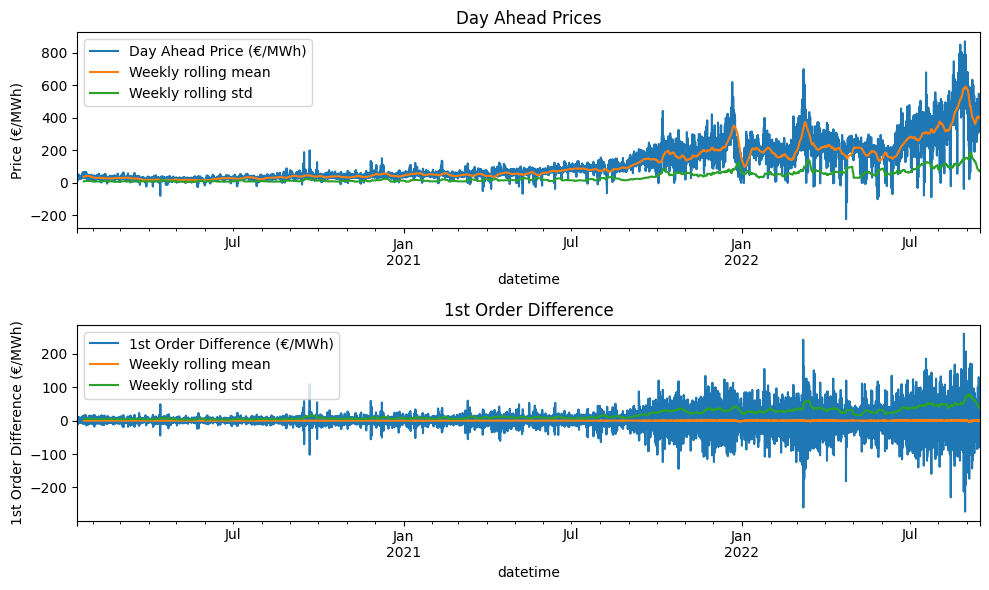

In [107]:
# Plot the hourly day ahead electricity price, along with the weekly rolling mean

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

df_train.set_index('datetime')[target_name].plot(ax=axs[0],
                                                                title='Day Ahead Prices + 48 hours',
                                                                label='Day Ahead Price (€/MWh)',
                                                                ylabel='Price (€/MWh)')
df_train.set_index('datetime')[target_name].rolling(24*7).mean().plot(ax=axs[0], label='Weekly rolling mean')
df_train.set_index('datetime')[target_name].rolling(24*7).std().plot(ax=axs[0],label='Weekly rolling std')
axs[0].legend()

df_train.set_index('datetime')[target_name].diff().plot(ax=axs[1],
                                                               title='1st Order Difference',
                                                               label='1st Order Difference (€/MWh)',
                                                        ylabel='1st Order Difference (€/MWh)')
df_train.set_index('datetime')[target_name].diff().rolling(24*7).mean().plot(ax=axs[1], label='Weekly rolling mean')
df_train.set_index('datetime')[target_name].diff().rolling(24*7).std().plot(ax=axs[1],label='Weekly rolling std')
axs[1].legend()

plt.tight_layout()
plt.show()

In [108]:
df_train[target_name + "_first_diff"] = df_train[target_name].diff()

features = [target_name, target_name + "_first_diff"]

df_adfuller = [] 

for feature in features:

    temp_d = {}
    result = adfuller(df_train[feature].dropna().values)
    temp_d['Series Name'] = feature
    temp_d['ADF Statistic'] = result[0]
    temp_d['p-value'] = result[1]
    if temp_d['p-value'] <= 0.05:
        temp_d['Comment'] = "Reject H0, Data is stationary"
    elif temp_d['p-value'] > 0.05:
        temp_d['Comment'] = "Fail to reject H0, Data is non-stationary"
    
    df_adfuller.append(temp_d)

df_adfuller = pd.DataFrame(df_adfuller)
df_adfuller

,Series Name,ADF Statistic,p-value,Comment
0,day_ahead_prices,-3.172374,0.02164,"Reject H0, Data is stationary"
1,day_ahead_prices_first_diff,-28.713881,0.00000,"Reject H0, Data is stationary"


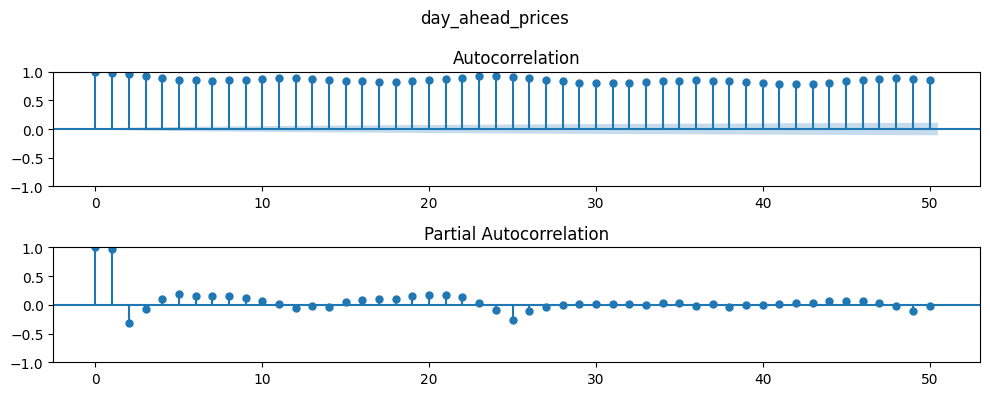

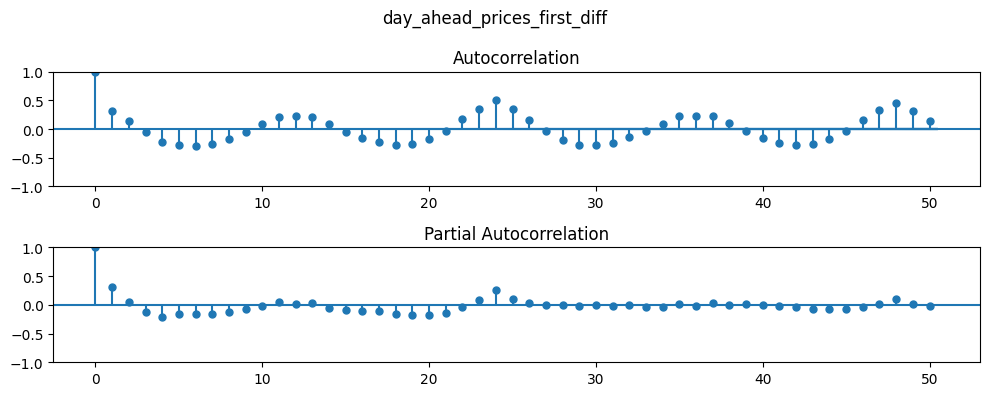

In [110]:
# Plot autocorrelation and partial autocorrelation plots

for feature in [target_name, target_name + "_first_diff"]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 4))
    plot_acf(df_train[feature].dropna(), lags=50, ax=axs[0])
    plot_pacf(df_train[feature].dropna(), lags=50, ax=axs[1])
    fig.suptitle(feature)
    plt.tight_layout()
    plt.show()
    
df_train = df_train.drop(target_name + "_first_diff", axis=1)

Although we fail to reject the null hypothesis of the Augmentented Dicky Fuller test, the plot of the time series does not look fully stationary so I will take the first difference.

The significant spike at lag 1 in the PACF plot above suggests a AR(1) and the significant spike at 24 suggests a seasonal AR(1) component.

The significant spike at lag 1 in the ACF plot above suggests a MA(2) and the significant spike at 24 suggests a seasonal MA(1) component.

This suggests a SARIMAX(1, 1, 1)x(1, 0, 1, 24) model. I will also fit the auto_arima to this time series to confirm these parameter selections

In [87]:
# Fit auto_arima function
data = df_train.set_index('datetime')[target_name].iloc[-200:]
stepwise_fit = auto_arima(data, max_p = 3, max_q = 3, m = 24, stepwise = True)     

In [88]:
# To print the summary 
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  200
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 24)   Log Likelihood                -949.274
Date:                              Tue, 30 Apr 2024   AIC                           1908.548
Time:                                      16:22:49   BIC                           1925.040
Sample:                                  09-06-2022   HQIC                          1915.222
                                       - 09-14-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9249      1.260      1.528      0.127      -0.544       4.394
ar.L1          0.8686      0.032     27.223      0.000       0.806       0.931
ar.S.L24       0.9642      0.021     45.933      0.000       0.923       1.005
ma.S.L24      -0.6631      0.100     -6.650      0.000      -0.858      -0.468
sigma2       674.3641     68.505      9.844      0.000     540.096     808.632
===================================================================================
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (JB):                 1.86
Prob(Q):                              0.31   Prob(JB):                         0.39
Heteroskedasticity (H):               0.96   Skew:                            -0.15
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Due to the time requried to fit the auto_arima funtion, I just fit it to the last 200 observations in the training set. The best model fit using auto_arima was SARIMAX(1, 0, 0)x(1, 0, 1, 24). I will fit all three models and compare their performance on the validation set.

####################
####################
Fitting SARIMAX(1, 0, 0)x(1, 0, 1, 24)

                                      SARIMAX Results                                       
Dep. Variable:                     day_ahead_prices   No. Observations:                23376
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 24)   Log Likelihood              -99532.070
Date:                              Tue, 30 Apr 2024   AIC                         199072.140
Time:                                      16:28:30   BIC                         199104.378
Sample:                                  01-15-2020   HQIC                        199082.608
                                       - 09-14-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0

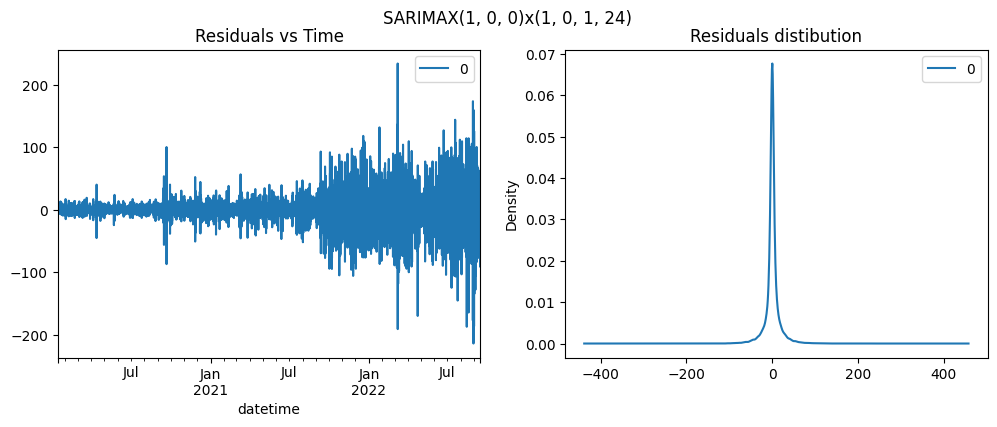

####################
####################
####################
####################
Fitting SARIMAX(1, 1, 1)x(1, 0, 1, 24)

                                     SARIMAX Results                                      
Dep. Variable:                   day_ahead_prices   No. Observations:                23376
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood              -99481.219
Date:                            Tue, 30 Apr 2024   AIC                         198972.438
Time:                                    16:29:05   BIC                         199012.735
Sample:                                01-15-2020   HQIC                        198985.523
                                     - 09-14-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

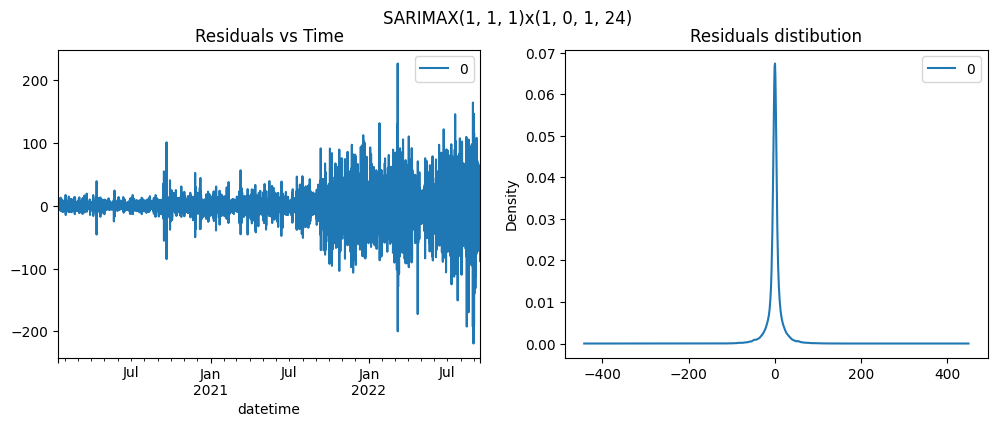

####################
####################


c:\users\seamu\.pyenv\.kindred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\seamu\.pyenv\.kindred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


####################
####################
Fitting SARIMAX(2, 1, 1)x(1, 0, 1, 24)

                                     SARIMAX Results                                      
Dep. Variable:                   day_ahead_prices   No. Observations:                23376
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 24)   Log Likelihood              -99490.949
Date:                            Tue, 30 Apr 2024   AIC                         198993.897
Time:                                    16:29:57   BIC                         199042.254
Sample:                                01-15-2020   HQIC                        199009.600
                                     - 09-14-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9272      0.003

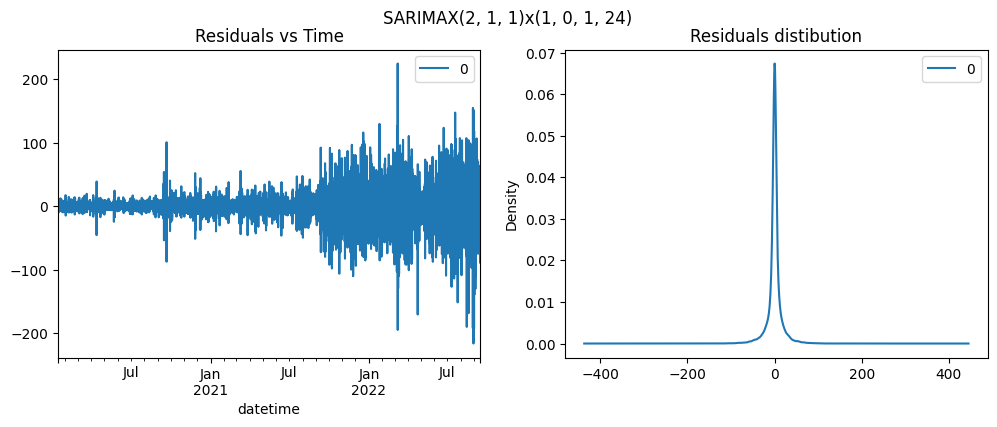

####################
####################


In [91]:
data = df_train.set_index('datetime')[target_name]
data.index.freq = 'h'

# SARIMAX(1, 0, 0)x(1, 0, 1, 24)
model_SARIMAX1 = SARIMAX(data, order=(1,0,0), seasonal_order=(1, 0, 1, 24)).fit()
statsmodel_fit_summary(model_SARIMAX1, "SARIMAX(1, 0, 0)x(1, 0, 1, 24)")

# SARIMAX(1, 1, 1)x(1, 0, 1, 24)
model_SARIMAX1 = SARIMAX(data, order=(1,1,1), seasonal_order=(1, 0, 1, 24)).fit()
statsmodel_fit_summary(model_SARIMAX1, "SARIMAX(1, 1, 1)x(1, 0, 1, 24)")

# SARIMAX(2, 1, 1)x(1, 0, 1, 24)
model_SARIMAX1 = SARIMAX(data, order=(2,1,1), seasonal_order=(1, 0, 1, 24)).fit()
statsmodel_fit_summary(model_SARIMAX1, "SARIMAX(2, 1, 1)x(1, 0, 1, 24)")

AIC is minimised by SARIMAX(2, 1, 1)x(1, 0, 1, 24)

I will choose between these three models and the number of training days to use by using the first 28 days of the validation set

In [48]:
n_val_days = 14
horizon = 24
val_startdate = df_val["datetime"].dt.date.min()
y_val = df_val[target_name].values[:24 * n_val_days]
train_days = [100, 200, 300]
temp_dict_pred_val= {}

dict_models = {
    'arima1':{
        'order':(1,1,1),
        'seasonal_order':(1, 0, 1, 24)
    },
    'arima2':{
        'order':(2,1,1),
        'seasonal_order':(1, 0, 1, 24)
    },
    'arima3':{
        'order':(1,0,0),
        'seasonal_order':(1, 0, 1, 24)
    }
}

mlflow.set_experiment("/electricity-prices-sarimax-hyperparameteropt")

rws = RollingWindowSarimax()
df_arima_hypopt, _ = rws.train_models(df, target_name, y_val, dict_models, train_days, n_val_days, val_startdate, 
                                      temp_dict_pred_val, calc_rmae=False)

df_arima_hypopt = pd.DataFrame(df_arima_hypopt)

.\predictions\predictions_val_arima1_train_100d_2022-09-15.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-16.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-17.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-18.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-19.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-20.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-21.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-22.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-23.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-24.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-25.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-26.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022

.\predictions\predictions_val_arima3_train_300d_2022-09-15.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-16.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-17.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-18.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-19.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-20.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-21.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-22.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-23.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-24.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-25.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-26.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022

In [49]:
df_arima_hypopt.sort_values(['mae', 'rmse']).round(2)

,dataset,model,rmse,r2,mape,smape,mae,rmae
4,val,arima2_train_200d,6.97,0.75,4.069189e+15,22.50,48.58,NaN
3,val,arima2_train_100d,6.99,0.75,4.018474e+15,22.73,48.84,NaN
5,val,arima2_train_300d,7.41,0.65,6.424344e+15,24.12,54.96,NaN
6,val,arima3_train_100d,7.62,0.58,6.241994e+15,25.93,58.14,NaN
7,val,arima3_train_200d,7.76,0.54,6.450581e+15,26.56,60.22,NaN
8,val,arima3_train_300d,7.80,0.54,6.543931e+15,26.77,60.81,NaN
1,val,arima1_train_200d,8.24,0.51,6.197059e+15,29.44,67.93,NaN
0,val,arima1_train_100d,8.26,0.51,6.182519e+15,29.61,68.25,NaN
2,val,arima1_train_300d,8.34,0.49,6.386197e+15,30.20,69.62,NaN


SARIMAX(2, 1, 1)x(1, 0, 1, 24) trained for 200 training days produced the best validation performance

In [30]:
n_val_days = (len(df_val) // 24) - 6
val_startdate = df_val["datetime"].dt.date.min()
y_val = df_val[target_name].values[:24 * n_val_days]
train_days = [200]

dict_models = {
#     'arima4':{
#         'order':(2,2,1),
#         'seasonal_order':(1, 0, 1, 24)
#     },
    'arima2':{
        'order':(2,1,1),
        'seasonal_order':(1, 0, 1, 24)
    }
}

mlflow.set_experiment("/electricity-prices")

rws = RollingWindowSarimax()
res_arima, dict_pred_val = rws.train_models(df, target_name, y_val, dict_models, train_days, n_val_days, val_startdate,
                                            dict_pred_val, calc_rmae=False)

.\predictions\predictions_val_arima2_train_200d_2022-09-15.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-16.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-17.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-18.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-19.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-20.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-21.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-22.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-23.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-24.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-25.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-26.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022

## Linear Models

In [31]:
covariate_names = [col for col in df_train.columns if ("holiday_" not in col)]
covariate_names.remove('datetime')
covariate_names.remove(target_name)
binary_covariate_names = ['is_holiday', 'weekend']
cat_covariate_names = ["month", "hour_of_day", "day_of_week"]

n_val_days = len(df_val) // 24
val_startdate = df_val["datetime"].dt.date.min()
y_val = df_val[target_name].values[:24 * n_val_days]

rwsklm = RollingWindowSklearnModels()

I will tune the hyperparamters for these models using the first 14 days of the validation set

### Lasso

In [63]:
dict_models = {
    'lasso': {
        'model_instance': Lasso(random_state=0),
        'model_params':{
            'alpha':[0.001]
        },
        'n_train_days':[len(df_train) // 24]
    }
}

temp_dict_pred_train = {}
temp_dict_pred_val= {}

mlflow.set_experiment("/electricity-prices-lasso-hyperparameteropt")
_, _, _ = rwsklm.train_models(df, y_val, dict_models, n_val_days, val_startdate, target_name, covariate_names, 
                              binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val, 
                              scale_data=False, calc_rmae=False)

.\predictions\predictions_train_lasso_alpha_0.001_train_977d_2022-09-11.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.001_train_977d_2022-09-11.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.001_train_977d_2022-09-12.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.001_train_977d_2022-09-12.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.001_train_977d_2022-09-13.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.001_train_977d_2022-09-13.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.001_train_977d_2022-09-14.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.001_train_977d_2022-09-14.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.001_train_977d_2022-09-15.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.001_train_977d_2022-09-15.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.001_train_977d_2022-09-16.npy exists, loadin

.\predictions\predictions_train_lasso_alpha_0.001_train_977d_2023-01-16.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.001_train_977d_2023-01-16.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.001_train_977d_2023-01-17.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.001_train_977d_2023-01-17.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.001_train_977d_2023-01-18.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.001_train_977d_2023-01-18.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.001_train_977d_2023-01-19.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.001_train_977d_2023-01-19.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.001_train_977d_2023-01-20.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.001_train_977d_2023-01-20.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.001_train_977d_2023-01-21.npy exists, loadin

The best validation performance is achieved using alpha = 0.01

### Ridge

In [64]:
dict_models = {
    'ridge': {
        'model_instance': Ridge(random_state=0),
        'model_params':{
            'alpha':[100000.0]
        },
        'n_train_days':[len(df_train) // 24]
    }
}

temp_dict_pred_train = {}
temp_dict_pred_val= {}

mlflow.set_experiment("/electricity-prices-ridge-hyperparameteropt")

_, _, _ = rwsklm.train_models(df, y_val, dict_models, n_val_days, val_startdate, target_name, covariate_names, 
                              binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val, 
                              scale_data=False, calc_rmae=False)

.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-09-11.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-09-11.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-09-12.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-09-12.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-09-13.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-09-13.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-09-14.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-09-14.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-09-15.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-09-15.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_9

.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-11-03.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-11-03.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-11-04.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-11-04.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-11-05.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-11-05.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-11-06.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-11-06.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-11-07.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-11-07.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_9

.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-12-17.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-12-18.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-12-18.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-12-19.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-12-19.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-12-20.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-12-20.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-12-21.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2022-12-21.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2022-12-22.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977

.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2023-02-10.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2023-02-10.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2023-02-11.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2023-02-11.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2023-02-12.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2023-02-12.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2023-02-13.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2023-02-13.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2023-02-14.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2023-02-14.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_9

.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2023-04-08.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2023-04-08.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2023-04-09.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2023-04-09.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2023-04-10.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2023-04-10.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2023-04-11.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2023-04-11.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_977d_2023-04-12.npy exists, loading
.\predictions\predictions_val_ridge_alpha_100000.0_train_977d_2023-04-12.npy exists, loading
.\predictions\predictions_train_ridge_alpha_100000.0_train_9

The best validation performance is achieved using alpha = 10000

### Elastic Net

In [68]:
dict_models = {
    'elasticnet': {
        'model_instance': ElasticNet(random_state=0),
        'model_params':{
            'alpha':[0.1],
            'l1_ratio':[0.2, 0.4]
        },
        'n_train_days':[len(df_train) // 24]
    },
    
}

temp_dict_pred_train = {}
temp_dict_pred_val= {}

mlflow.set_experiment("/electricity-prices-elasticnet-hyperparameteropt")

_, _, _ = rwsklm.train_models(df, y_val, dict_models, n_val_days, val_startdate, target_name, covariate_names, 
                              binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val, 
                              scale_data=False, calc_rmae=False)

Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-01-07_2022-09-10.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-01-07_2022-09-10.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-09-11.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-01-07_2022-09-10.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-09-11.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-01-08_2022-09-11.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-01-08_2022-09-11.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-09-12.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-01-08_2022-09-11.pkl exists, loading
Saving .\predictions\predictions_val_el

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-01-23_2022-09-26.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-09-27.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-01-23_2022-09-26.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-09-27.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-01-24_2022-09-27.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-01-24_2022-09-27.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-09-28.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-01-24_2022-09-27.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-09-28.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-02-08_2022-10-12.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-13.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-02-08_2022-10-12.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-13.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-02-09_2022-10-13.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-02-09_2022-10-13.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-14.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-02-09_2022-10-13.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-14.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-02-24_2022-10-28.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-29.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-02-24_2022-10-28.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-29.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-02-25_2022-10-29.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-02-25_2022-10-29.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-30.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-02-25_2022-10-29.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-30.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-03-11_2022-11-13.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-11-14.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-03-11_2022-11-13.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-11-14.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-03-12_2022-11-14.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-03-12_2022-11-14.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-11-15.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-03-12_2022-11-14.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-11-15.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-03-27_2022-11-29.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-11-30.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-03-27_2022-11-29.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-11-30.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-03-28_2022-11-30.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-03-28_2022-11-30.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-01.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-03-28_2022-11-30.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-01.npy
Saving .\models\model_cache_elasticnet_alpha_0.

Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-04-12_2022-12-15.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-04-12_2022-12-15.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-16.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-04-12_2022-12-15.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-16.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-04-13_2022-12-16.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-04-13_2022-12-16.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-17.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-04-13_2022-12-16.pkl exists, loading
Saving .\predictions\predictions_val_el

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-04-28_2022-12-31.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-01-01.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-04-28_2022-12-31.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-01-01.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-04-29_2023-01-01.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-04-29_2023-01-01.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-01-02.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-04-29_2023-01-01.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-01-02.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-05-14_2023-01-16.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-01-17.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-05-14_2023-01-16.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-01-17.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-05-15_2023-01-17.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-05-15_2023-01-17.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-01-18.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-05-15_2023-01-17.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-01-18.npy
Saving .\models\model_cache_elasticnet_alpha_0.

Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-05-30_2023-02-01.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-05-30_2023-02-01.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-02.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-05-30_2023-02-01.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-02.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-05-31_2023-02-02.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-05-31_2023-02-02.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-03.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-05-31_2023-02-02.pkl exists, loading
Saving .\predictions\predictions_val_el

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-06-15_2023-02-17.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-18.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-06-15_2023-02-17.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-18.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-06-16_2023-02-18.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-06-16_2023-02-18.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-19.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-06-16_2023-02-18.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-19.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-07-01_2023-03-05.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-06.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-07-01_2023-03-05.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-06.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-07-02_2023-03-06.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-07-02_2023-03-06.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-07.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-07-02_2023-03-06.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-07.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-07-17_2023-03-21.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-22.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-07-17_2023-03-21.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-22.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-07-18_2023-03-22.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-07-18_2023-03-22.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-23.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-07-18_2023-03-22.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-23.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-08-02_2023-04-06.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-04-07.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-08-02_2023-04-06.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-04-07.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-08-03_2023-04-07.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-08-03_2023-04-07.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-04-08.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-08-03_2023-04-07.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-04-08.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-08-18_2023-04-22.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-04-23.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-08-18_2023-04-22.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-04-23.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-08-19_2023-04-23.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-08-19_2023-04-23.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-04-24.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-08-19_2023-04-23.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-04-24.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-09-03_2023-05-08.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-05-09.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-09-03_2023-05-08.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-05-09.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-09-04_2023-05-09.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-09-04_2023-05-09.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-05-10.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_train_2020-09-04_2023-05-09.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-05-10.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-01-19_2022-09-22.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-09-23.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-01-19_2022-09-22.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-09-23.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-01-20_2022-09-23.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-01-20_2022-09-23.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-09-24.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-01-20_2022-09-23.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-09-24.npy
Saving .\models\model_cache_elasticnet_alpha_0.

Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-02-04_2022-10-08.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-02-04_2022-10-08.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-10-09.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-02-04_2022-10-08.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-10-09.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-02-05_2022-10-09.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-02-05_2022-10-09.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-10-10.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-02-05_2022-10-09.pkl exists, loading
Saving .\predictions\predictions_val_el

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-02-20_2022-10-24.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-10-25.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-02-20_2022-10-24.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-10-25.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-02-21_2022-10-25.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-02-21_2022-10-25.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-10-26.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-02-21_2022-10-25.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-10-26.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-03-07_2022-11-09.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-11-10.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-03-07_2022-11-09.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-11-10.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-03-08_2022-11-10.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-03-08_2022-11-10.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-11-11.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-03-08_2022-11-10.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-11-11.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-03-23_2022-11-25.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-11-26.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-03-23_2022-11-25.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-11-26.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-03-24_2022-11-26.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-03-24_2022-11-26.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-11-27.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-03-24_2022-11-26.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-11-27.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-04-08_2022-12-11.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-12-12.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-04-08_2022-12-11.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-12-12.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-04-09_2022-12-12.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-04-09_2022-12-12.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-12-13.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-04-09_2022-12-12.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-12-13.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-04-24_2022-12-27.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-12-28.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-04-24_2022-12-27.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-12-28.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-04-25_2022-12-28.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-04-25_2022-12-28.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-12-29.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-04-25_2022-12-28.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2022-12-29.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-05-10_2023-01-12.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-01-13.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-05-10_2023-01-12.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-01-13.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-05-11_2023-01-13.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-05-11_2023-01-13.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-01-14.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-05-11_2023-01-13.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-01-14.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-05-26_2023-01-28.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-01-29.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-05-26_2023-01-28.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-01-29.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-05-27_2023-01-29.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-05-27_2023-01-29.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-01-30.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-05-27_2023-01-29.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-01-30.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-06-11_2023-02-13.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-02-14.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-06-11_2023-02-13.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-02-14.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-06-12_2023-02-14.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-06-12_2023-02-14.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-02-15.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-06-12_2023-02-14.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-02-15.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-06-27_2023-03-01.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-03-02.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-06-27_2023-03-01.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-03-02.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-06-28_2023-03-02.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-06-28_2023-03-02.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-03-03.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-06-28_2023-03-02.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-03-03.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-07-13_2023-03-17.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-03-18.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-07-13_2023-03-17.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-03-18.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-07-14_2023-03-18.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-07-14_2023-03-18.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-03-19.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-07-14_2023-03-18.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-03-19.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-07-29_2023-04-02.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-04-03.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-07-29_2023-04-02.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-04-03.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-07-30_2023-04-03.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-07-30_2023-04-03.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-04-04.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-07-30_2023-04-03.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-04-04.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-08-14_2023-04-18.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-04-19.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-08-14_2023-04-18.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-04-19.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-08-15_2023-04-19.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-08-15_2023-04-19.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-04-20.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-08-15_2023-04-19.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-04-20.npy
Saving .\models\model_cache_elasticnet_alpha_0.

.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-08-30_2023-05-04.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-05-05.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-08-30_2023-05-04.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-05-05.npy
Saving .\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-08-31_2023-05-05.pkl
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-08-31_2023-05-05.pkl exists, loading
Saving .\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-05-06.npy
.\models\model_cache_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_train_2020-08-31_2023-05-05.pkl exists, loading
Saving .\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.4_train_977d_2023-05-06.npy
Saving .\models\model_cache_elasticnet_alpha_0.

The best validation performance is achieved using alpha=0.1 and l1_ratio=0.2. 

Generate results for the full validation set using the optimial hyperparameters

In [32]:
n_val_days = len(df_val) // 24
y_val = df_val[target_name].values[:24 * n_val_days]

dict_models = {
    'lasso': {
        'model_instance': Lasso(random_state=0),
        'model_params':{
            'alpha':[0.01]
        }
        ,
        'n_train_days':[len(df_train) // 24]
    },
    'ridge': {
        'model_instance': Ridge(random_state=0),
        'model_params':{
            'alpha':[10000.0]
        },
        'n_train_days':[len(df_train) // 24]
        
    },
    'elasticnet': {
        'model_instance': ElasticNet(random_state=0),
        'model_params':{
            'alpha':[0.1],
            'l1_ratio':[0.2]
        },
        'n_train_days':[len(df_train) // 24]
    },    
}

mlflow.set_experiment("/electricity-prices")

res_linear, dict_pred_train, dict_pred_val = rwsklm.train_models(df, y_val, dict_models, n_val_days, val_startdate, 
                                                                 target_name, covariate_names, binary_covariate_names, 
                                                                 cat_covariate_names, dict_pred_train, dict_pred_val, 
                                                                 scale_data=False, calc_rmae=False)

.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2022-09-11.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2022-09-11.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2022-09-12.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2022-09-12.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2022-09-13.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2022-09-13.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2022-09-14.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2022-09-14.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2022-09-15.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2022-09-15.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2022-09-16.npy exists, loading
.\predict

.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2022-11-11.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2022-11-11.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2022-11-12.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2022-11-12.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2022-11-13.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2022-11-13.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2022-11-14.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2022-11-14.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2022-11-15.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2022-11-15.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2022-11-16.npy exists, loading
.\predict

.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2023-01-12.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2023-01-12.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2023-01-13.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2023-01-13.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2023-01-14.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2023-01-14.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2023-01-15.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2023-01-15.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2023-01-16.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2023-01-16.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2023-01-17.npy exists, loading
.\predict

.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2023-03-10.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2023-03-11.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2023-03-11.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2023-03-12.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2023-03-12.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2023-03-13.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2023-03-13.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2023-03-14.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2023-03-14.npy exists, loading
.\predictions\predictions_train_lasso_alpha_0.01_train_977d_2023-03-15.npy exists, loading
.\predictions\predictions_val_lasso_alpha_0.01_train_977d_2023-03-15.npy exists, loading
.\predictio

.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2022-09-11.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2022-09-11.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2022-09-12.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2022-09-12.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2022-09-13.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2022-09-13.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2022-09-14.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2022-09-14.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2022-09-15.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2022-09-15.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2022-09

.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2022-11-01.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2022-11-02.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2022-11-02.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2022-11-03.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2022-11-03.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2022-11-04.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2022-11-04.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2022-11-05.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2022-11-05.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2022-11-06.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2022-11-0

.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-01-01.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-01-02.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-01-02.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-01-03.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-01-03.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-01-04.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-01-04.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-01-05.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-01-05.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-01-06.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-01-0

.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-02-28.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-03-01.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-03-01.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-03-02.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-03-02.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-03-03.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-03-03.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-03-04.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-03-04.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-03-05.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-03-0

.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-04-20.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-04-21.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-04-21.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-04-22.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-04-22.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-04-23.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-04-23.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-04-24.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-04-24.npy exists, loading
.\predictions\predictions_train_ridge_alpha_10000.0_train_977d_2023-04-25.npy exists, loading
.\predictions\predictions_val_ridge_alpha_10000.0_train_977d_2023-04-2

.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-19.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-20.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-20.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-21.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-21.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-22.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-22.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-23.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-10-23.npy exists, loading
.\predictions\predictions_train_elasti

.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-13.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-14.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-14.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-15.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-15.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-16.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-16.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-17.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2022-12-17.npy exists, loading
.\predictions\predictions_train_elasti

.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-01-31.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-01.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-01.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-02.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-02.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-03.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-03.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-04.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-02-04.npy exists, loading
.\predictions\predictions_train_elasti

.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-25.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-26.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-26.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-27.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-27.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-28.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-28.npy exists, loading
.\predictions\predictions_train_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-29.npy exists, loading
.\predictions\predictions_val_elasticnet_alpha_0.1_l1_ratio_0.2_train_977d_2023-03-29.npy exists, loading
.\predictions\predictions_train_elasti

## Light GBM

In [180]:
# covariate_names = [col for col in df_train.columns if ("holiday_" not in col)]

# cols_2_remove = ['datetime', target_name]

# for col in cols_2_remove:
#     covariate_names.remove(col)
    
# discrete_features  =  ['month', 'is_holiday', 'weekend', 'hour_of_day', 'day_of_week']
# ind_discrete_features = [i for i, feature in enumerate(covariate_names) if feature in discrete_features]
    
# df_y = df_train[target_name].copy()
# df_X = df_train[covariate_names].copy()
# df_X["noise_1"] = np.random.normal(loc=0.0, scale=1.0, size=len(df_X))
# df_X["noise_2"] = np.random.normal(loc=0.0, scale=2.0, size=len(df_X))

# model = LGBMRegressor(random_state=0, verbosity=-1)
# model.fit(df_X.values, df_y.values, categorical_feature=ind_discrete_features)
# feat_imp = pd.Series(model.feature_importances_)
# feat_imp.index = df_X.columns
# feat_imp = feat_imp.sort_values(ascending=False)
# max_noise_imp = max(feat_imp["noise_1"], feat_imp["noise_2"])
# feat_imp = feat_imp[feat_imp>max_noise_imp]
# covariate_names = feat_imp[feat_imp>max_noise_imp].index.to_list()
# feat_imp

day_ahead_prices                                   175
day_ahead_prices_lag_120                           167
generation_fossil_gas_missing_qty_lag_120          118
month                                              114
generation_Biomass                                 104
pressure_weighted                                   95
generation_fossil_gas_missing_qty                   92
hour_of_day                                         84
generation_forecast_lag_120                         83
day_of_week                                         80
pressure_weighted_lag_120                           78
dew_point_weighted                                  78
generation_Fossil Hard coal_lag_120                 68
generation_Nuclear                                  68
generation_Waste                                    67
generation_Biomass_lag_120                          67
generation_Fossil Hard coal                         66
generation_Wind_lag_120                             66
imports_la

In [181]:
# covariate_names

['day_ahead_prices',
 'day_ahead_prices_lag_120',
 'generation_fossil_gas_missing_qty_lag_120',
 'month',
 'generation_Biomass',
 'pressure_weighted',
 'generation_fossil_gas_missing_qty',
 'hour_of_day',
 'generation_forecast_lag_120',
 'day_of_week',
 'pressure_weighted_lag_120',
 'dew_point_weighted',
 'generation_Fossil Hard coal_lag_120',
 'generation_Nuclear',
 'generation_Waste',
 'generation_Biomass_lag_120',
 'generation_Fossil Hard coal',
 'generation_Wind_lag_120',
 'imports_lag_120',
 'Forecasted Load_lag_120',
 'generation_Waste_lag_120',
 'generation_forecast_Wind_lag_120',
 'generation_Nuclear_lag_120',
 'dew_point_weighted_lag_120',
 'generation_Fossil Gas',
 'generation_Fossil Gas_lag_120',
 'temp_weighted',
 'generation_forecast_Wind',
 'generation_fossil_hard_coal_missing_qty_lag_120',
 'generation_Wind',
 'temp_weighted_lag_120',
 'generation_fossil_hard_coal_missing_qty',
 'imports',
 'residual_load_lag_120',
 'crossborder_flow_net_lag_120',
 'generation_forecast',

In [19]:
covariate_names = [
    'day_ahead_prices',
    'day_ahead_prices_lag_120',
    'generation_fossil_gas_missing_qty_lag_120',
    'month',
    'generation_Biomass',
    'pressure_weighted',
    'generation_fossil_gas_missing_qty',
    'hour_of_day',
    'generation_forecast_lag_120',
    'day_of_week',
    'pressure_weighted_lag_120',
    'dew_point_weighted',
    'generation_Fossil Hard coal_lag_120',
    'generation_Nuclear',
    'generation_Waste',
    'generation_Biomass_lag_120',
    'generation_Fossil Hard coal',
    'generation_Wind_lag_120',
    'imports_lag_120',
    'Forecasted Load_lag_120',
    'generation_Waste_lag_120',
    'generation_forecast_Wind_lag_120',
    'generation_Nuclear_lag_120',
    'dew_point_weighted_lag_120',
    'generation_Fossil Gas',
    'generation_Fossil Gas_lag_120',
    'temp_weighted',
    'generation_forecast_Wind',
    'generation_fossil_hard_coal_missing_qty_lag_120',
    'generation_Wind',
    'temp_weighted_lag_120',
    'generation_fossil_hard_coal_missing_qty',
    'imports',
    'residual_load_lag_120',
    'crossborder_flow_net_lag_120',
    'generation_forecast',
    'humidity_weighted_lag_120',
    'residual_load',
    'RLI_24',
    'crossborder_flow_net',
    'RLI_48',
    'humidity_weighted',
    'generation_Other_lag_120',
    'generation_Solar',
    'wind_speed_weighted_lag_120',
    'generation_total',
    'generation_Solar_lag_120',
    'wind_speed_weighted',
    'Forecasted Load',
    'weekend',
    'generation_Other',
    'generation_forecast_Solar_lag_120',
    'generation_total_lag_120',
    'generation_forecast_Solar',
    'RLI_168',
    'is_holiday'
]

cols_2_remove = ['month']
for col in cols_2_remove:
    covariate_names.remove(col)

In [20]:
bo_lgbm = BayesianOptimisationLgbm()
discrete_features = ['month', 'is_holiday', 'weekend', 'hour_of_day', 'day_of_week']
val_startdate = df_val["datetime"].dt.date.min()
n_val_days = len(df_val) // 24
n_splits = 10
max_evals = 100
list_n_train_days = [100, 200, 400, len(df_train) // 24]

param_space = {'num_leaves': scope.int(hp.quniform('num_leaves', 2, 16, 2)),
               'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
               'max_depth': scope.int(hp.quniform('max_depth', 2, 10, 1)),
               'subsample': hp.uniform('subsample', 0.3, 1),
               'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
               'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 100, 1)),
               'reg_alpha': hp.uniform('reg_alpha', 0, 1),
               'reg_lambda': hp.uniform('reg_lambda', 0, 1),
               'n_estimators': scope.int(hp.quniform('num_iterations', 5, 400, 1)),
               'objective': hp.choice('objective', ['regression', 'regression_l1']),
               'n_jobs': -1,
               'random_state': 0,
               'verbosity': -1,
               'early_stopping_round': 20
               }

int_parameters = ['num_leaves', 'max_depth', 'n_estimators', 'num_iterations', 'min_child_samples']
option_parameters={'objective':['regression', 'regression_l1']}

model_name = "light_gbm_hyperopt"

for n_train_days in list_n_train_days:
    print("#" * 100)
    print(f"Number of training days = {n_train_days}")
    print("\n")

    temp_covariate_names = deepcopy(covariate_names)
    if n_train_days >= 365:
        temp_covariate_names.append('month')

    temp = bo_lgbm.get_opt_hyperparams(df, model_name, target_name, temp_covariate_names, discrete_features,
                                       val_startdate, n_train_days, n_val_days, n_splits, param_space, max_evals,
                                       int_parameters, option_parameters)
    print(f"Optimal hyperparameter values:")
    print(temp)

####################################################################################################
Number of training days = 100


100%|████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/trial, best loss: 23.0917534489665]
Saving .\models\hyperparams_light_gbm_hyperopt_100d.pkl
Optimal hyperparameter values:
{'colsample_bytree': 0.629879573507568, 'learning_rate': 0.14917289633300876, 'max_depth': 3, 'min_child_samples': 74, 'num_iterations': 148, 'num_leaves': 16, 'objective': 'regression_l1', 'reg_alpha': 0.9215768368268054, 'reg_lambda': 0.5276787950297885, 'subsample': 0.7399781084034586}
####################################################################################################
Number of training days = 200


100%|██████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/trial, best loss: 25.455142953831988]
Saving .\models\hyperparams_light_gbm_hyperopt_200d.pkl
Optimal hyperparameter values:
{'colsample_bytree': 0.7837901

In [23]:
n_val_days = len(df_val) // 24
val_startdate = df_val["datetime"].dt.date.min()
y_val = df_val[target_name].values[:24 * n_val_days]

binary_covariate_names = ['month', 'is_holiday', 'weekend', 'hour_of_day', 'day_of_week']
cat_covariate_names = None
list_n_train_days = [100, 200, 400, len(df_train) // 24]

rwsklm = RollingWindowSklearnModels()

temp_dict_pred_train = {}
temp_dict_pred_val= {}

mlflow.set_experiment("/electricity-prices-lightgbm-hyperparameteropt")

model_name = "light_gbm_hyperopt"

for n_train_days in list_n_train_days:
    filename = f".\\models\\hyperparams_{model_name}_{n_train_days}d.pkl"
    params = rwsklm.load_model_cache(filename)

    params["n_estimators"] = params.pop('num_iterations')
    
    temp_covariate_names = deepcopy(covariate_names)
    if n_train_days >= 365:
        temp_covariate_names.append('month')

    dict_models = {
        model_name: {
            'model_instance': LGBMRegressor(n_jobs=-1, random_state=0, verbosity=-1, early_stopping_round=20, **params),
            'model_params': {},
            'n_train_days': [n_train_days],
            'use_early_stopping': True
        }
    }

    _, _, _ = rwsklm.train_models(df, y_val, dict_models, n_val_days, val_startdate, target_name, temp_covariate_names,
                                  binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val,
                                  scale_data=False, calc_rmae=False)

.\models\hyperparams_light_gbm_hyperopt_100d.pkl exists, loading
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-09-11.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-09-11.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-09-12.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-09-12.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-09-13.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-09-13.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-09-14.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-09-14.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-09-15.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-09-15.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-09-16.npy
Saving .\predictions\

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-10-31.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-10-31.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-11-01.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-11-01.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-11-02.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-11-02.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-11-03.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-11-03.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-11-04.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-11-04.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-11-05.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-11-05.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-12-20.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-12-20.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-12-21.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-12-21.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-12-22.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-12-22.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-12-23.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-12-23.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-12-24.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-12-24.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2022-12-25.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2022-12-25.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2023-02-09.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2023-02-09.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2023-02-10.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2023-02-10.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2023-02-11.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2023-02-11.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2023-02-12.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2023-02-12.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2023-02-13.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2023-02-13.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2023-02-14.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2023-02-14.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2023-03-31.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2023-03-31.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2023-04-01.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2023-04-01.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2023-04-02.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2023-04-02.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2023-04-03.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2023-04-03.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2023-04-04.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2023-04-04.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_100d_2023-04-05.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_100d_2023-04-05.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-09-17.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-09-17.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-09-18.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-09-18.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-09-19.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-09-19.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-09-20.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-09-20.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-09-21.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-09-21.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-09-22.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-09-22.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-11-06.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-11-06.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-11-07.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-11-07.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-11-08.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-11-08.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-11-09.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-11-09.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-11-10.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-11-10.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-11-11.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-11-11.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-12-27.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-12-27.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-12-28.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-12-28.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-12-29.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-12-29.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-12-30.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-12-30.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2022-12-31.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2022-12-31.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-01-01.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-01-01.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-02-15.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-02-15.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-02-16.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-02-16.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-02-17.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-02-17.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-02-18.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-02-18.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-02-19.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-02-19.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-02-20.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-02-20.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-04-07.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-04-07.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-04-08.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-04-08.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-04-09.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-04-09.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-04-10.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-04-10.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-04-11.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-04-11.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_200d_2023-04-12.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_200d_2023-04-12.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-09-24.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-09-24.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-09-25.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-09-25.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-09-26.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-09-26.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-09-27.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-09-27.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-09-28.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-09-28.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-09-29.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-09-29.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-11-13.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-11-13.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-11-14.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-11-14.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-11-15.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-11-15.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-11-16.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-11-16.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-11-17.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-11-17.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-11-18.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-11-18.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-01-02.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-01-02.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-01-03.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-01-03.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-01-04.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-01-04.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-01-05.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-01-05.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-01-06.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-01-06.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-01-07.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-01-07.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-02-21.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-02-21.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-02-22.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-02-22.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-02-23.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-02-23.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-02-24.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-02-24.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-02-25.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-02-25.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-02-26.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-02-26.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-04-12.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-04-12.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-04-13.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-04-13.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-04-14.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-04-14.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-04-15.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-04-15.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-04-16.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-04-16.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-04-17.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-04-17.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2022-09-29.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2022-09-29.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2022-09-30.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2022-09-30.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2022-10-01.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2022-10-01.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2022-10-02.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2022-10-02.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2022-10-03.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2022-10-03.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2022-10-04.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2022-10-04.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2022-11-18.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2022-11-18.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2022-11-19.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2022-11-19.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2022-11-20.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2022-11-20.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2022-11-21.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2022-11-21.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2022-11-22.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2022-11-22.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2022-11-23.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2022-11-23.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-01-07.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-01-07.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-01-08.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-01-08.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-01-09.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-01-09.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-01-10.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-01-10.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-01-11.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-01-11.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-01-12.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-01-12.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-02-26.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-02-26.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-02-27.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-02-27.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-02-28.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-02-28.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-03-01.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-03-01.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-03-02.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-03-02.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-03-03.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-03-03.npy
Savi

Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-04-17.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-04-17.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-04-18.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-04-18.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-04-19.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-04-19.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-04-20.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-04-20.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-04-21.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-04-21.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt_train_977d_2023-04-22.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt_train_977d_2023-04-22.npy
Savi

In [25]:
y_train_temp = df_train[target_name].copy().values[:10*24]
X_train_temp = df_train[covariate_names].copy().values[:10*24]
dt_train_temp = df_train['datetime'].copy()[:10*24]
y_val_temp = df_train[target_name].copy().values[10*24:12*24]
X_val_temp = df_train[covariate_names].copy().values[10*24:12*24]

model_name = "light_gbm_hyperopt"
n_train_days = 400

filename = f".\\models\\hyperparams_{model_name}_{n_train_days}d.pkl"
params = rwsklm.load_model_cache(filename)
params["n_estimators"] = params.pop('num_iterations')

temp_covariate_names = deepcopy(covariate_names)
if n_train_days >= 365:
    temp_covariate_names.append('month')

discrete_features  =  ['month', 'is_holiday', 'weekend', 'hour_of_day', 'day_of_week']
ind_discrete_features = [i for i, feature in enumerate(temp_covariate_names) if feature in discrete_features]

model = LGBMRegressor(n_jobs=-1, random_state=0, verbosity=-1, early_stopping_round=20, **params)
model.fit(X_train_temp, y_train_temp, categorical_feature=ind_discrete_features, eval_set=[(X_val_temp, y_val_temp)])
pred_temp = model.predict(X_temp)

temp_data =  np.concatenate([y_temp.reshape(-1,1), pred_temp.reshape(-1,1)], axis=1)
df_temp = pd.DataFrame(data= temp_data, columns=['ground_truth','pred'], index=dt_temp)

.\models\hyperparams_light_gbm_hyperopt_400d.pkl exists, loading


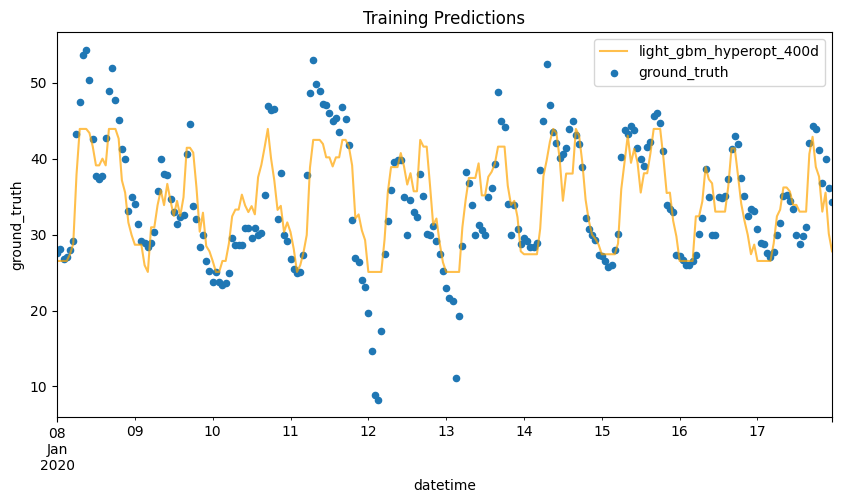

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
df_temp['pred'].plot(ax=ax, label=f"{model_name}_{n_train_days}d", color='orange', alpha=0.7, title='Training Predictions')
df_temp.reset_index().plot.scatter(x='datetime', y='ground_truth',ax=ax, label='ground_truth')
ax.legend()
plt.show()

In [ ]:
# n_val_days = len(df_val) // 24
# val_startdate = df_val["datetime"].dt.date.min()
# y_val = df_val[target_name].values[:24 * n_val_days]

# cols_2_remove = ['is_holiday', 'month']

# for col in cols_2_remove:
#     covariate_names.remove(col)

# binary_covariate_names = None
# cat_covariate_names = ['weekend', 'hour_of_day', 'day_of_week']

# dict_models = {
#     'light_gbm': {
#         'model_instance': LGBMRegressor(random_state=0, verbosity=-1),
#         'model_params':{
#             'objective': ["mae"],
#             'n_estimators':[300],
#             'num_leaves':[9],
#         },
#         'n_train_days':[100]
#     }
# }

# rwsklm = RollingWindowSklearnModels()

# temp_dict_pred_train = {}
# temp_dict_pred_val= {}

# mlflow.set_experiment("/electricity-prices-lightgbm-hyperparameteropt")

# _, _, _ = rwsklm.train_models(df, y_val, dict_models, n_val_days, val_startdate, target_name, covariate_names,
#                               binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val, 
#                               scale_data=False, calc_rmae=False)

In [34]:
n_val_days = len(df_val) // 24
val_startdate = df_val["datetime"].dt.date.min()
y_val = df_val[target_name].values[:24 * n_val_days]

binary_covariate_names = ['month', 'is_holiday', 'weekend', 'hour_of_day', 'day_of_week']
cat_covariate_names = None

list_n_train_days = [400]

rwsklm = RollingWindowSklearnModels()

mlflow.set_experiment("/electricity-prices")

model_name = "light_gbm_hyperopt"

for n_train_days in list_n_train_days:
    filename = f".\\models\\hyperparams_{model_name}_{n_train_days}d.pkl"
    params = rwsklm.load_model_cache(filename)

    params["n_estimators"] = params.pop('num_iterations')
    
    temp_covariate_names = deepcopy(covariate_names)
    if n_train_days >= 365:
        temp_covariate_names.append('month')

    dict_models = {
        model_name: {
            'model_instance': LGBMRegressor(n_jobs=-1, random_state=0, verbosity=-1, early_stopping_round=20, **params),
            'model_params': {},
            'n_train_days': [n_train_days],
            'use_early_stopping': True
        }
    }

    res_lgbm, dict_pred_train, dict_pred_val = rwsklm.train_models(df, y_val, dict_models, n_val_days, val_startdate, target_name, 
                                                                   covariate_names, binary_covariate_names, cat_covariate_names, 
                                                                   dict_pred_train, dict_pred_val, scale_data=False, calc_rmae=True)

.\models\hyperparams_light_gbm_hyperopt_400d.pkl exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-09-11.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-09-11.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-09-12.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-09-12.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-09-13.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-09-13.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-09-14.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-09-14.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-09-15.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-09-15.npy exists, loading
.\predictions\p

.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-11-29.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-11-30.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-11-30.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-12-01.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-12-01.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-12-02.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-12-02.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-12-03.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-12-03.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2022-12-04.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2022-12-04.npy exist

.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-02-09.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-02-09.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-02-10.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-02-10.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-02-11.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-02-11.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-02-12.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-02-12.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-02-13.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-02-13.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-02-14.npy exi

.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-04-15.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-04-15.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-04-16.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-04-16.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-04-17.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-04-17.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-04-18.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-04-18.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-04-19.npy exists, loading
.\predictions\predictions_val_light_gbm_hyperopt_train_400d_2023-04-19.npy exists, loading
.\predictions\predictions_train_light_gbm_hyperopt_train_400d_2023-04-20.npy exi

In [35]:
df_res = pd.DataFrame(res_naive + res_linear + res_lgbm)
df_res.sort_values(['mae']).round(2)

,dataset,model,rmse,r2,mape,smape,mae,rmae
4,train,lasso_alpha_0.01_train_977d,5.38,0.83,1.020295e+15,29.46,28.90,NaN
8,train,elasticnet_alpha_0.1_l1_ratio_0.2_train_977d,5.39,0.83,1.039293e+15,27.89,29.06,NaN
6,train,ridge_alpha_10000.0_train_977d,5.45,0.83,1.066340e+15,30.46,29.65,NaN
2,train,naive_minus_2_days,5.59,0.77,7.788552e+14,33.63,31.29,NaN
0,train,naive_minus_7_days,5.61,0.77,6.955024e+14,31.50,31.51,NaN
11,val,light_gbm_hyperopt_train_400d,5.86,0.76,2.144918e+15,26.90,34.32,0.57
10,train,light_gbm_hyperopt_train_400d,6.12,0.81,1.536790e+15,23.77,37.43,NaN
9,val,elasticnet_alpha_0.1_l1_ratio_0.2_train_977d,6.62,0.62,2.245462e+15,32.31,43.82,NaN
5,val,lasso_alpha_0.01_train_977d,6.63,0.63,2.246941e+15,32.65,43.99,NaN
7,val,ridge_alpha_10000.0_train_977d,6.67,0.63,2.372122e+15,32.40,44.48,NaN


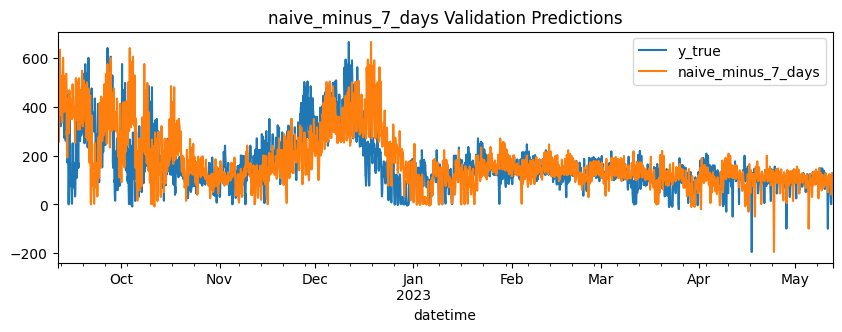

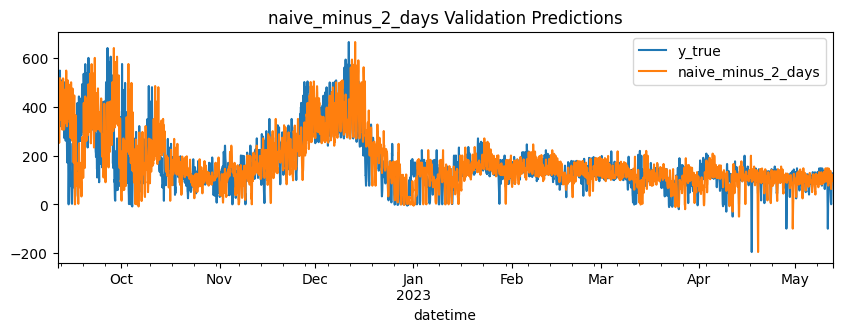

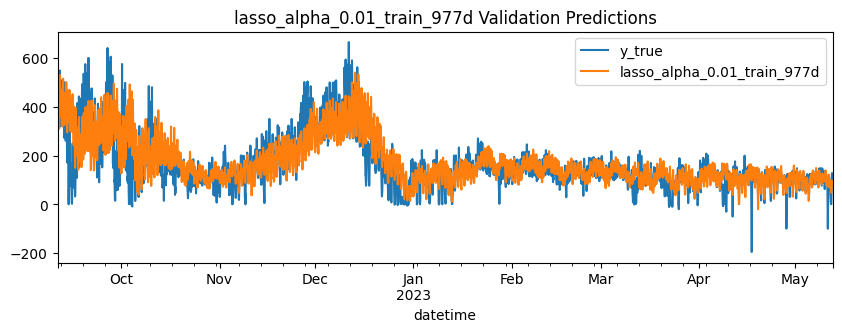

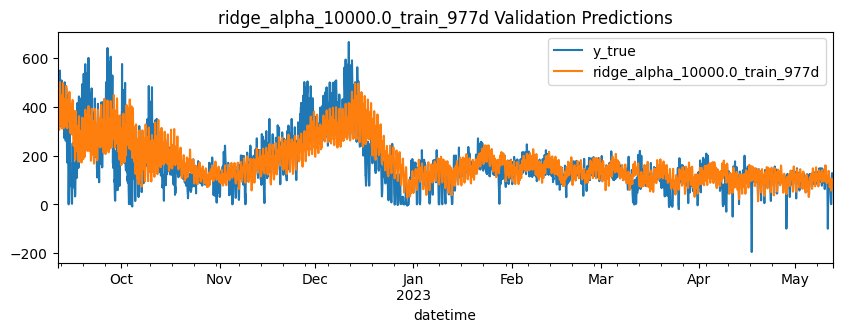

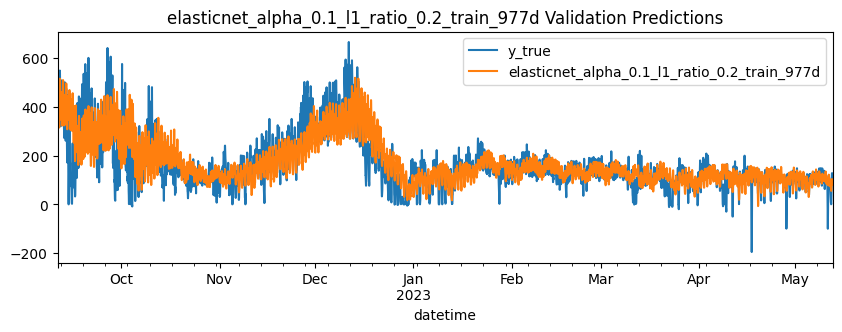

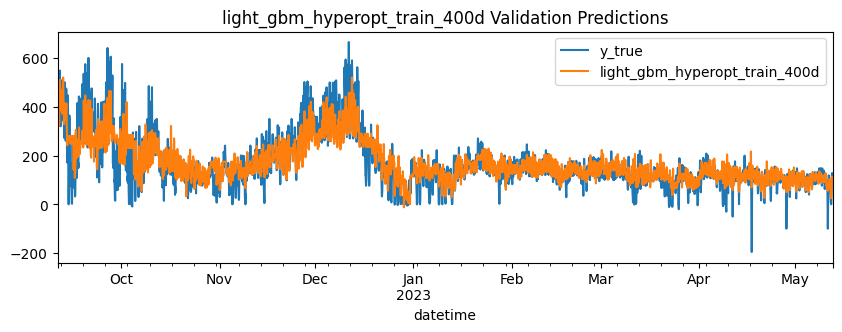

In [36]:
df_ae = []

for model in dict_pred_val.keys():
    fig, ax = plt.subplots(figsize=(10, 3))
    true = df_val.iloc[:24 * n_val_days].set_index("datetime")[target_name]
    pred = pd.DataFrame(dict_pred_val[model],columns=[model], index=true.index)
    ae = np.abs(true.values - pred[model].values)
    df_ae.append(pd.DataFrame(ae,columns=[model], index=true.index))
    true.plot(ax=ax, label='y_true', title=f'{model} Validation Predictions')
    pred.plot(ax=ax, label=model)                                   
    ax.legend()

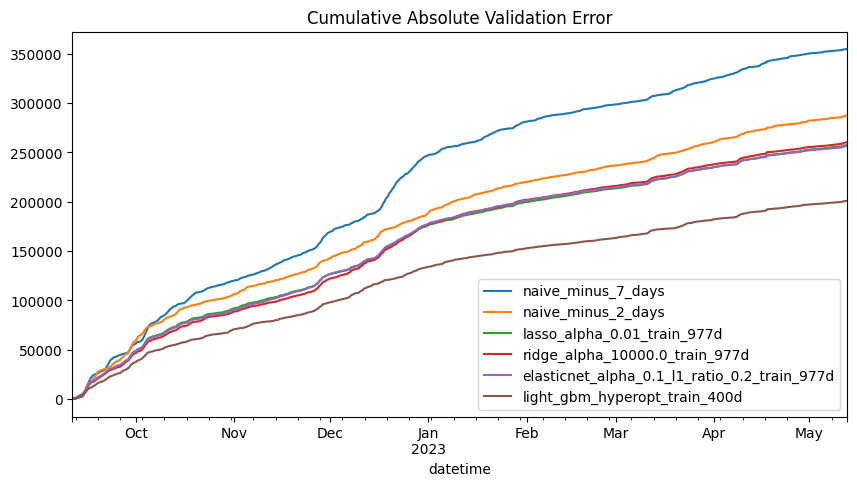

In [37]:
df_ae = pd.concat(df_ae, axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
df_ae.cumsum().plot(ax=ax, title=f'Cumulative Absolute Validation Error')
ax.legend()

## GAM

In [70]:
n_val_days = len(df_val) // 24
y_val = df_val[target_name].values[:24 * n_val_days]
val_startdate = df_val["datetime"].dt.date.min()

rwlg = RollingWindowLinearGam()

In [73]:
covariate_names = [col for col in df_train.columns if ("holiday_" not in col)]

cols_2_remove = ['datetime', target_name]

for col in cols_2_remove:
    covariate_names.remove(col)
    
discrete_features  =  ['month', 'is_holiday', 'weekend', 'hour_of_day', 'day_of_week']
ind_discrete_features = [i for i, feature in enumerate(covariate_names) if feature in discrete_features]
    
df_y = df_train[target_name].copy()
df_X = df_train[covariate_names].copy()

mutual_info = mutual_info_regression(df_X, df_y, discrete_features=ind_discrete_features)
mutual_info = pd.Series(mutual_info)
mutual_info.index = df_X.columns
mutual_info = mutual_info.sort_values(ascending=False)
mutual_info

day_ahead_prices_lag_120                           1.025859
day_ahead_prices                                   0.946776
generation_fossil_gas_missing_qty_lag_120          0.634711
generation_fossil_gas_missing_qty                  0.608783
generation_fossil_hard_coal_missing_qty_lag_120    0.580432
generation_fossil_hard_coal_missing_qty            0.573288
generation_Nuclear_lag_120                         0.401010
generation_Nuclear                                 0.389156
generation_Fossil Hard coal_lag_120                0.371345
generation_Fossil Hard coal                        0.334944
generation_Biomass_lag_120                         0.334643
generation_Biomass                                 0.331503
month                                              0.295602
imports_lag_120                                    0.259171
imports                                            0.257733
generation_Solar                                   0.176692
generation_Solar_lag_120                

### 50 training days

In [ ]:
covariate_names = mutual_info.index.to_list()
covariate_names.remove('month')
binary_covariate_names = ['is_holiday', 'weekend', 'hour_of_day', 'day_of_week']
cat_covariate_names = None
n_train_day = 50
use_grid_search = True
n_parameter_trials = 25
lamda_alpha = 0
lamda_beta = 2

_, _, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names, 
                                                     binary_covariate_names, cat_covariate_names, print_summary=True,
                                                     use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                     lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day)

In [ ]:
use_grid_search = True
n_parameter_trials = 25
lamda_alpha = 0
lamda_beta = 3

_, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names, 
                                                     binary_covariate_names, cat_covariate_names, print_summary=True,
                                                     use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                     lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day)

In [ ]:
covariate_names = mutual_info[mutual_info > 0.1].index.to_list()
covariate_names.remove('month')
binary_covariate_names = None
cat_covariate_names = None
list_alphas = [0]
list_betas = [2, 3]
params = [list_alphas, list_betas]
params = list(itertools.product(*params))
train_days = [50]
tensor_term_names = None


mlflow.set_experiment("/electricity-prices-lineargam-hyperparameteropt")

for temp_lamda_alpha, temp_lamda_beta in params:
    temp_dict_pred_train, temp_dict_pred_val = {}, {}
    _,_,_ = rwlg.train_models(df, y_val, train_days, n_val_days, val_startdate, target_name, covariate_names, 
                              binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val, 
                              tensor_term_names=tensor_term_names, use_grid_search=True, n_parameter_trials=25, 
                              lamda_alpha=temp_lamda_alpha, lamda_beta=temp_lamda_beta)

For many feature it is hard to see if there is a significant relationship with the target. I will experiment with increasing the lambda value to avoid modelling too much noise

In [ ]:
use_grid_search = True
n_parameter_trials = 25
lamda_alpha = 0
lamda_beta = 2

_, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names, 
                                                     binary_covariate_names, cat_covariate_names, print_summary=True,
                                                     use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                     lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
use_grid_search = True
n_parameter_trials = 25
lamda_alpha = 0
lamda_beta = 3

_, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names, 
                                                     binary_covariate_names, cat_covariate_names, print_summary=True,
                                                     use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                     lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day)

In [14]:
covariate_names_reduced = [
    'day_ahead_prices',
    'generation_Biomass',
    'generation_Fossil Gas',
    'generation_Fossil Hard coal',
    'generation_Nuclear',
    'generation_Other',
    'generation_Solar',
    'generation_Waste',
    'crossborder_flow_net',
    'imports',
    'Forecasted Load',
    'generation_forecast',
    'generation_forecast_Solar',
    'generation_total',
    'residual_load',
    'generation_Wind',
    'generation_forecast_Wind',
    'dew_point_weighted',
    'temp_weighted',
    'pressure_weighted',
    'humidity_weighted',
    'wind_speed_weighted',
    'generation_fossil_gas_missing_qty',
    'generation_fossil_hard_coal_missing_qty',
    'generation_nuclear_missing_qty',
    'hour_of_day',
    'day_of_week',
    'weekend',
    'is_holiday',
    'RLI_24',
    'RLI_48',
    'RLI_168',
    'day_ahead_prices_lag_1',
    'day_ahead_prices_lag_2',
    'day_ahead_prices_lag_24',
    'day_ahead_prices_lag_48',
    'day_ahead_prices_lag_72',
    'day_ahead_prices_lag_96',
    'day_ahead_prices_lag_120',
    'generation_Biomass_lag_24',
    'generation_Wind_lag_24',
    'generation_Wind_lag_48',
]

In [ ]:
use_grid_search = True
n_parameter_trials = 100
lamda_alpha = 0
lamda_beta = 2

mlflow.set_experiment("/electricity-prices-lineargam-hyperparameteropt")

_, _, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names_reduced,
                                                        binary_covariate_names, cat_covariate_names, print_summary=True,
                                                        use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                        lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day, figsize=(20,20))

In [ ]:
use_grid_search = True
n_parameter_trials = 100
lamda_alpha = 0
lamda_beta = 3

_, _, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names_reduced,
                                                        binary_covariate_names, cat_covariate_names, print_summary=True,
                                                        use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                        lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day, figsize=(20,20))

In [ ]:
covariate_names = [
    'day_ahead_prices',
    'generation_Biomass',
    'generation_Fossil Gas',
    'generation_Fossil Hard coal',
    'generation_Nuclear',
    'generation_Other',
    'generation_Solar',
    'generation_Waste',
    'crossborder_flow_net',
    'imports',
    'Forecasted Load',
    'generation_forecast',
    'generation_forecast_Solar',
    'generation_total',
    'residual_load',
    'generation_Wind',
    'generation_forecast_Wind',
    'dew_point_weighted',
    'temp_weighted',
    'pressure_weighted',
    'humidity_weighted',
    'wind_speed_weighted',
    'generation_fossil_gas_missing_qty',
    'generation_fossil_hard_coal_missing_qty',
    'generation_nuclear_missing_qty',
    'hour_of_day',
    'day_of_week',
    'weekend',
    'is_holiday',
    'RLI_24',
    'RLI_48',
    'RLI_168',
    'day_ahead_prices_lag_1',
    'day_ahead_prices_lag_2',
    'day_ahead_prices_lag_24',
    'day_ahead_prices_lag_48',
    'day_ahead_prices_lag_72',
    'day_ahead_prices_lag_96',
    'day_ahead_prices_lag_120',
    'generation_Biomass_lag_24',
    'generation_Wind_lag_24',
    'generation_Wind_lag_48',
]

binary_covariate_names = ["hour_of_day", "day_of_week", "weekend", "is_holiday"]
cat_covariate_names = None
list_alphas = [0]
list_betas = [2, 3]
params = [list_alphas, list_betas]
params = list(itertools.product(*params))
train_days = [50]
tensor_term_names = None


mlflow.set_experiment("/electricity-prices-lineargam-hyperparameteropt")

for temp_lamda_alpha, temp_lamda_beta in params:
    temp_dict_pred_train, temp_dict_pred_val = {}, {}
    _,_,_ = rwlg.train_models(df, y_val, train_days, n_val_days, val_startdate, target_name, covariate_names, 
                              binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val, 
                              tensor_term_names=tensor_term_names, use_grid_search=True, n_parameter_trials=100, 
                              lamda_alpha=temp_lamda_alpha, lamda_beta=temp_lamda_beta)

In [167]:
covariate_names_reduced = [
    'generation_Biomass',
    'generation_Nuclear',
    'residual_load',
    'dew_point_weighted',
    'pressure_weighted',
    'generation_fossil_hard_coal_missing_qty',
    'hour_of_day',
    'day_of_week',
    'day_ahead_prices_lag_24',
    'day_ahead_prices_lag_48',
    'day_ahead_prices_lag_120',
    'generation_Biomass_lag_24',
]


In [ ]:
use_grid_search = True
n_parameter_trials = 200
lamda_alpha = 0
lamda_beta = 2

_, _, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names_reduced,
                                                        binary_covariate_names, cat_covariate_names, print_summary=True,
                                                        use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                        lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day, figsize=(20, 15))

In [ ]:
use_grid_search = True
n_parameter_trials = 200
lamda_alpha = 0
lamda_beta = 3

_, _, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names_reduced,
                                                        binary_covariate_names, cat_covariate_names, print_summary=True,
                                                        use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                        lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day, figsize=(20, 15))

In [203]:
covariate_names_reduced = [
    'generation_Biomass',
    'generation_Nuclear',
    'dew_point_weighted',
    'pressure_weighted',
    'generation_fossil_hard_coal_missing_qty',
    'hour_of_day',
    'day_of_week',
    'day_ahead_prices_lag_24',
    'day_ahead_prices_lag_120',
    'generation_Biomass_lag_24',
]


In [ ]:
temp_covariate_names = [
    'generation_Biomass',
    'generation_Nuclear',
    'dew_point_weighted',
    'pressure_weighted',
    'generation_fossil_hard_coal_missing_qty',
    'day_ahead_prices_lag_24',
    'day_ahead_prices_lag_120',
    'generation_Biomass_lag_24',
]

df_y = df_train[target_name].copy()
df_X = df_train[temp_covariate_names].copy()

df_interactions = rwlg.get_interaction_terms(df_X, df_y, temp_covariate_names)
tensor_term_names = df_interactions.index.to_list()
df_interactions

In [ ]:
use_grid_search = True
n_parameter_trials = 100
lamda_alpha = 0
lamda_beta = 3
tensor_term_names = df_interactions.index.to_list()

_, _, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names_reduced,
                                                        binary_covariate_names, cat_covariate_names, tensor_term_names, 
                                                        print_summary=True, use_grid_search=use_grid_search, 
                                                        n_parameter_trials=n_parameter_trials,
                                                        lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}_interactions_True"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day, figsize=(20,10))

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}_interactions_True"

rwlg.plot_partial_dependence_tensor(temp_model_name, val_startdate, n_train_day, figsize=(20, 10))

In [ ]:
list_tensor_term_names = [None, tensor_term_names]
list_alphas = [0]
list_betas = [2, 3]
params = [list_tensor_term_names, list_alphas, list_betas]
params = list(itertools.product(*params))
params

In [ ]:
covariate_names = [
    'generation_Biomass',
    'generation_Nuclear',
    'dew_point_weighted',
    'pressure_weighted',
    'generation_fossil_hard_coal_missing_qty',
    'hour_of_day',
    'day_of_week',
    'day_ahead_prices_lag_24',
    'day_ahead_prices_lag_120',
    'generation_Biomass_lag_24',
]

binary_covariate_names = ["hour_of_day", "day_of_week"]
cat_covariate_names = None
list_tensor_term_names = [tensor_term_names]
list_alphas = [0]
list_betas = [2, 3]
params = [list_tensor_term_names, list_alphas, list_betas]
params = list(itertools.product(*params))
train_days = [50]


mlflow.set_experiment("/electricity-prices-lineargam-hyperparameteropt")

for temp_tensor_term_names, temp_lamda_alpha, temp_lamda_beta in params:
    temp_dict_pred_train, temp_dict_pred_val = {}, {}
    _,_,_ = rwlg.train_models(df, y_val, train_days, n_val_days, val_startdate, target_name, covariate_names, 
                              binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val, 
                              tensor_term_names=temp_tensor_term_names, use_grid_search=True, n_parameter_trials=100, 
                              lamda_alpha=temp_lamda_alpha, lamda_beta=temp_lamda_beta)

In [ ]:
train_days = [50]
temp_dict_pred_train, temp_dict_pred_val = {}, {}
lamda_alpha_beta = [(0, 3)]

mlflow.set_experiment("/electricity-prices-lineargam-hyperparameteropt")

for lamda_alpha, lamda_beta in lamda_alpha_beta:
    _,_,_ = rwlg.train_models(df, y_val, train_days, n_val_days, val_startdate, target_name, covariate_names, 
                              binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val, 
                              use_grid_search=True, n_parameter_trials=100, lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
n_val_days = len(df_val) // 24
train_days = [50]
y_val = df_val[target_name].values[:24 * n_val_days]
use_grid_search = True
n_parameter_trials = 100
lamda_alpha = 0 
lamda_beta = 3

mlflow.set_experiment("/electricity-prices")

res_gam, _,_ = rwlg.train_models(df, y_val, train_days, n_val_days, val_startdate, target_name, covariate_names, 
                                 binary_covariate_names, cat_covariate_names, dict_pred_train, dict_pred_val, 
                                 use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials, 
                                 lamda_alpha=lamda_alpha, lamda_beta=lamda_beta, calc_rmae=True)

In [ ]:
# df_res = pd.DataFrame(res_naive + res_arima + res_linear + res_gam)
df_res = pd.DataFrame(res_naive + res_linear + res_gam)
df_res.sort_values(['mae']).round(2)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
test.cumsum().plot(ax=ax)
ax.legend()

In [ ]:
# Generate test predictions

covariate_names = [col for col in df_train.columns if ("holiday_" not in col)]
covariate_names.remove('datetime')
covariate_names.remove(target_name)
binary_covariate_names = ['is_holiday', 'weekend']
cat_covariate_names = ["month", "hour_of_day", "day_of_week"]

n_test_days = len(df_test) // 24
test_startdate = df_test["datetime"].dt.date.min()
test_enddate = df_test["datetime"].dt.date.max()
train_days = [len(df_train) // 24]
y_test = df_test[target_name].values[:24 * n_test_days]

df_out = df_test.set_index("datetime")[target_name].to_frame().rename(columns={target_name:"ground_truth"})


dict_models = {
    'ridge': {
        'model_instance': Ridge(random_state=0),
        'model_params':{
            'alpha':[1075.0]
        },
        'n_train_days':[len(df_train) // 24]
        
    },
}

temp_dict_pred_train, temp_dict_pred_val = {}, {}

_, temp_dict_pred_train, temp_dict_pred_val = train_linear_models(df, y_test, dict_models, n_test_days, test_startdate,
                                                                  target_name, covariate_names, binary_covariate_names, 
                                                                  cat_covariate_names, temp_dict_pred_train, 
                                                                  temp_dict_pred_val, calc_rmae=False)

df_out["Prediction"] =  list(temp_dict_pred_val.values())[0]
filename_output = f".\\app\\backend\\predictions_test_{list(temp_dict_pred_val.keys())[0]}_{str(test_startdate)}_{str(test_enddate)}.csv"
df_out.to_csv(filename_output)